#### 도착한 LED와 시뮬레이션 vs 실제 실험

### 실험 장치 도면

![장치 도면](dimension.png)

> 노트북과 동일한 폴더의 `dimension.png`를 표시합니다.


한 가운데를 기준으로 할 때, uv 4개, white 4개

uv 1 = [4.43, 1.25]   
uv 2 = [1.55, a]   
uv 3 = - uv1   
uv4 = -uv2

distance between led - illum plane : 6.0 - (0.4 + 0.4 + 2.2) ~= 3.0

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## 1. 빔 방사각 함수 정의 (passivation 효과 반영)
def get_beam_intensity_at_angle(angle_degrees, spread_angle_degrees=0):
    original_angles = np.array([0, 20, 30, 40, 90])
    intensities = np.array([1.0, 0.95, 0.9, 0.8, 0.0])

    adjusted_angles = original_angles + spread_angle_degrees
    adjusted_angles[0] = 0 

    f = interp1d(adjusted_angles, intensities, kind='linear', fill_value="extrapolate")

    if angle_degrees < 0 or angle_degrees > 90 + spread_angle_degrees:
        return 0.0
    return max(0.0, f(angle_degrees).item())

## 2. LED SMD 위치 설정 및 조명 시뮬레이션 함수 (4개 LED로 복원)
def simulate_illumination(target_z_mm=3.00, grid_size_mm=10, resolution=100, spread_angle_degrees=0):
    # led 1
    x_1 = 4.43
    y_1 = 1.25
    # led 2
    x_2 = 1.55
    y_2 = - 5.21 # 4.43 * (45.5/141) from pixel length !!

    led_positions = [
        np.array([x_1, y_1, 0]),     # X축 양의 방향
        np.array([x_2, y_2, 0]),    # X축 음의 방향
        np.array([-x_1, -y_1, 0]),     # Y축 양의 방향
        np.array([-x_2, -y_2, 0])     # Y축 음의 방향
    ]

    x = np.linspace(-grid_size_mm / 2, grid_size_mm / 2, resolution)
    y = np.linspace(-grid_size_mm / 2, grid_size_mm / 2, resolution)
    X, Y = np.meshgrid(x, y)

    illumination_map = np.zeros_like(X)

    for led_pos in led_positions:
        target_points = np.stack([X, Y, np.full_like(X, target_z_mm)], axis=-1)
        vectors = target_points - led_pos
        distances = np.linalg.norm(vectors, axis=-1)
        
        distances = np.where(distances == 0, 1e-9, distances) 

        cos_theta = target_z_mm / distances
        cos_theta = np.clip(cos_theta, 0, 1)

        angle_degrees = np.degrees(np.arccos(cos_theta))
        
        relative_beam_intensity = np.array([get_beam_intensity_at_angle(a, spread_angle_degrees) for a in angle_degrees.flatten()]).reshape(resolution, resolution)
        
        intensity_contribution = relative_beam_intensity * cos_theta / (distances**2)
        illumination_map += intensity_contribution

    return X, Y, illumination_map

## 3. 삼각형으로 잘린 사각형 마스크 생성 함수 (RoundedRectangle 대체) - 현재 사용하지 않음
def create_triangular_cut_mask(X_mesh, Y_mesh, rect_width, rect_height, corner_cut_length):
    """
    주어진 메쉬 그리드에서 삼각형으로 모서리가 잘린 사각형 형태의 불리언 마스크를 생성합니다.
    corner_cut_length: 각 모서리에서 x, y 축을 따라 잘려나갈 길이 (mm).
    """
    mask = np.zeros(X_mesh.shape, dtype=bool)
    
    half_width = rect_width / 2
    half_height = rect_height / 2
    
    # 기본 사각형 영역 (아직 자르기 전)
    basic_square_mask = (np.abs(X_mesh) <= half_width) & (np.abs(Y_mesh) <= half_height)
    
    # 각 모서리 영역을 정의하고 해당 영역을 마스크에서 제외
    # 잘려나가는 선의 기울기가 1이라고 가정 (x+y = const)
    
    # 1사분면 (오른쪽 위) 잘린 영역: (X_mesh - (half_width - corner_cut_length)) + (Y_mesh - (half_height - corner_cut_length)) > corner_cut_length
    cut_mask_q1 = (X_mesh > (half_width - corner_cut_length)) & \
                  (Y_mesh > (half_height - corner_cut_length)) & \
                  ((X_mesh - (half_width - corner_cut_length)) + (Y_mesh - (half_height - corner_cut_length)) > corner_cut_length)

    # 2사분면 (왼쪽 위) 잘린 영역: (-(X_mesh + (half_width - corner_cut_length))) + (Y_mesh - (half_height - corner_cut_length)) > corner_cut_length
    cut_mask_q2 = (X_mesh < -(half_width - corner_cut_length)) & \
                  (Y_mesh > (half_height - corner_cut_length)) & \
                  (-(X_mesh + (half_width - corner_cut_length)) + (Y_mesh - (half_height - corner_cut_length)) > corner_cut_length)

    # 3사분면 (왼쪽 아래) 잘린 영역
    cut_mask_q3 = (X_mesh < -(half_width - corner_cut_length)) & \
                  (Y_mesh < -(half_height - corner_cut_length)) & \
                  (-(X_mesh + (half_width - corner_cut_length)) - (Y_mesh + (half_height - corner_cut_length)) > corner_cut_length) # x, y 모두 음수방향

    # 4사분면 (오른쪽 아래) 잘린 영역
    cut_mask_q4 = (X_mesh > (half_width - corner_cut_length)) & \
                  (Y_mesh < -(half_height - corner_cut_length)) & \
                  ((X_mesh - (half_width - corner_cut_length)) - (Y_mesh + (half_height - corner_cut_length)) > corner_cut_length) # y만 음수방향
    
    # 최종 마스크는 기본 사각형에서 잘린 영역을 제외한 부분
    mask = basic_square_mask & (~cut_mask_q1) & (~cut_mask_q2) & (~cut_mask_q3) & (~cut_mask_q4)
    
    return mask
    
## 4. 균일성(Uniformity) 평가 함수 정의 (마스크 적용)
def evaluate_uniformity(illumination_map, X_mesh, Y_mesh, object_width_mm, object_height_mm, corner_cut_length_mm, center_region_ratio=0.5):
    
    # 삼각형 마스크 대신 간단한 사각형 마스크 사용
    # object_mask = create_triangular_cut_mask(X_mesh, Y_mesh, object_width_mm, object_height_mm, corner_cut_length_mm)
    
    # 간단한 사각형 마스크로 대체
    half_width = object_width_mm / 2
    half_height = object_height_mm / 2
    object_mask = (np.abs(X_mesh) <= half_width) & (np.abs(Y_mesh) <= half_height)
    
    masked_illumination_map = np.where(object_mask, illumination_map, np.nan)

    min_intensity = np.nanmin(masked_illumination_map)
    max_intensity = np.nanmax(masked_illumination_map)
    
    if max_intensity == 0 or np.isnan(max_intensity):
        uniformity_min_max = 0
    else:
        uniformity_min_max = min_intensity / max_intensity
    
    uniformity_std = np.nanstd(masked_illumination_map)

    rows, cols = masked_illumination_map.shape
    
    center_rows_start = int(rows * (0.5 - center_region_ratio / 2))
    center_rows_end = int(rows * (0.5 + center_region_ratio / 2))
    center_cols_start = int(cols * (0.5 - center_region_ratio / 2))
    center_cols_end = int(cols * (0.5 + center_region_ratio / 2))

    center_region = masked_illumination_map[center_rows_start:center_rows_end, center_cols_start:center_cols_end]
    center_intensity_avg = np.nanmean(center_region)

    center_y_index = masked_illumination_map.shape[0] // 2 
    line_data_masked = masked_illumination_map[center_y_index, :] 
    
    valid_line_data = line_data_masked[~np.isnan(line_data_masked)]

    if len(valid_line_data) == 0:
        line_max_val = 0
        line_center_value = 0
        line_center_max_difference = np.inf 
    else:
        line_max_val = np.max(valid_line_data) 
        
        center_x_index_for_line = len(X_mesh[0, :]) // 2 
        line_center_value = line_data_masked[center_x_index_for_line] 

        if np.isnan(line_center_value):
            line_center_value = 0 
        
        line_center_max_difference = line_max_val - line_center_value 

    return uniformity_min_max, uniformity_std, center_intensity_avg, line_center_max_difference, X_mesh[0, :], line_data_masked, object_mask


## 5. 플롯 결과 시각화 함수 (인자 및 통계 계산 방식 변경)
def plot_results(target_z_mm, grid_dimension_mm, simulation_resolution, 
                 object_width_mm, object_height_mm, corner_cut_length_mm, 
                 passivation_spread_angle): # 통계 관련 인자들 제거 (함수 내에서 계산)

    # 이 p_mm_to_plot 값에 대해 시뮬레이션 및 평가를 다시 수행
    X, Y, illumination_full_for_plot = simulate_illumination(
        # p_mm=p_mm_to_plot,
        target_z_mm=target_z_mm,
        grid_size_mm=grid_dimension_mm,
        resolution=simulation_resolution,
        spread_angle_degrees=passivation_spread_angle 
    )
    
    # 해당 p_mm에 대한 균일성 지표들을 다시 계산 (플롯과 출력용)
    uniformity_min_max, uniformity_std, center_intensity_avg, line_center_max_difference, x_coords_line, current_line_data_full, object_mask_for_plot = evaluate_uniformity(
        illumination_full_for_plot, X, Y, object_width_mm, object_height_mm, corner_cut_length_mm
    )

    final_illumination_masked_for_plot = np.where(object_mask_for_plot, illumination_full_for_plot, np.nan)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7)) 

    # 첫 번째 서브플롯: 컬러맵 (마스크된 조명)
    im = axes[0].imshow(final_illumination_masked_for_plot, extent=[X.min(), X.max(), Y.min(), Y.max()], origin='lower', cmap='viridis', vmin=np.nanmin(final_illumination_masked_for_plot) if not np.all(np.isnan(final_illumination_masked_for_plot)) else 0, vmax=np.nanmax(final_illumination_masked_for_plot) if not np.all(np.isnan(final_illumination_masked_for_plot)) else 1)
    fig.colorbar(im, ax=axes[0], label='Illumination Intensity (Arb. Units)')
    axes[0].set_title(f'Illumination Map on Cut-Corner Object (Z = {target_z_mm} mm)\n(Actual LED positions, Spread = {passivation_spread_angle} deg, Cut={corner_cut_length_mm}mm)')
    axes[0].set_xlabel('X (mm)')
    axes[0].set_ylabel('Y (mm)')
    
    # 4개 LED SMD 위치 (점) - simulate_illumination에서 정의한 위치와 동일하게
    x_1 = 4.43
    y_1 = 1.25
    x_2 = 1.55
    y_2 = - 5.21 # 4.43 * (45.5/141) from pixel length
    
    plot_led_x_all = [x_1, x_2, -x_1, -x_2] 
    plot_led_y_all = [y_1, y_2, -y_1, -y_2]
    
    # 모든 LED 위치를 하나의 scatter 호출로 표시
    axes[0].scatter(plot_led_x_all, plot_led_y_all, 
                    color='blue', marker='o', s=100, label='LED Positions (Z=0)') 
    
    # 사각형 윤곽선 그리기 (삼각형 잘린 부분은 표시하지 않음)
    half_width = object_width_mm / 2
    half_height = object_height_mm / 2

    rect_x_coords = [-half_width, half_width, half_width, -half_width, -half_width]
    rect_y_coords = [half_height, half_height, -half_height, -half_height, half_height]

    axes[0].plot(rect_x_coords, rect_y_coords, 'w--', linewidth=2, label=f'Object {object_width_mm}x{object_height_mm}mm')
    
    # 추가 요청: 중심 원점의 4.44x2.5mm 흰색 점선 사각형 (Aperture)
    square_4_44_width = 10 # 가로 길이
    square_2_5_height = 10 # 세로 길이
    square_4_44_half_width = square_4_44_width / 2
    square_2_5_half_height = square_2_5_height / 2
    
    square_4_44_x = [-square_4_44_half_width, square_4_44_half_width, square_4_44_half_width, -square_4_44_half_width, -square_4_44_half_width]
    square_4_44_y = [square_2_5_half_height, square_2_5_half_height, -square_2_5_half_height, -square_2_5_half_height, square_2_5_half_height]
    axes[0].plot(square_4_44_x, square_4_44_y, 'w:', linewidth=2, label='object 10x10mm')

    # 추가 요청: 중심 원점의 7.55mm 빨간색 실선 정사각형 (LED Array Area)
    square_4_88_half = 7.55 / 2
    square_4_88_x = [-square_4_88_half, square_4_88_half, square_4_88_half, -square_4_88_half, -square_4_88_half]
    square_4_88_y = [square_4_88_half, square_4_88_half, -square_4_88_half, -square_4_88_half, square_4_88_half]
    axes[0].plot(square_4_88_x, square_4_88_y, 'r-', linewidth=1, label='LED Array Area 7.55x7.55mm') 

    # 추가 요청: 각 LED SMD 위치를 중심으로 하는 칩 크기 사각형 (X, Y축 LED 크기 다르게)
    # X축 LED 칩 크기 (가로: 2.3mm, 세로: 1.0mm)
    smd_x_width = 2.30
    smd_x_height = 1.0

    # Y축 LED 칩 크기 (가로: 1.0mm, 세로: 2.30mm)
    smd_y_width = 1.0
    smd_y_height = 2.30
    
    # 통합된 범례 라벨
    overall_smd_label_set = False # 첫 번째 LED에만 라벨을 붙이기 위한 플래그

    # 모든 4개 LED 위치에 대해 루프를 돌며 칩 크기 사각형 플롯
    for i in range(len(plot_led_x_all)): 
        led_x = plot_led_x_all[i]
        led_y = plot_led_y_all[i]
        
        # LED 위치에 따라 사용할 칩 크기 및 색상 선택
        if i == 1 or i == 3: # 첫 번째와 세 번째 LED (x_1, -x_1 위치)
            current_smd_width = smd_x_width
            current_smd_height = smd_x_height
            current_smd_color = 'b-'
            label_prefix = 'X-axis'
        else: # 두 번째와 네 번째 LED (x_2, -x_2 위치)
            current_smd_width = smd_y_width
            current_smd_height = smd_y_height
            current_smd_color = 'b-'
            label_prefix = 'Y-axis'
        
        smd_half_width = current_smd_width / 2
        smd_half_height = current_smd_height / 2

        smd_rect_x = [led_x - smd_half_width, led_x + smd_half_width, led_x + smd_half_width, led_x - smd_half_width, led_x - smd_half_width]
        smd_rect_y = [led_y + smd_half_height, led_y + smd_half_height, led_y - smd_half_height, led_y - smd_half_height, led_y + smd_half_height]
        
        # 첫 번째 LED 칩 사각형에만 통합 라벨을 붙임
        if not overall_smd_label_set:
            label_text = f'LED SMD Chip {smd_x_width}x{smd_x_height}mm'
            overall_smd_label_set = True
        else:
            label_text = None
            
        axes[0].plot(smd_rect_x, smd_rect_y, current_smd_color, linewidth=1, label=label_text)

    # 레전드 위치 수정: 우측 최상단으로 이동
    axes[0].legend(loc='upper right') 
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # 두 번째 서브플롯: y=0 라인 플롯 (마스크된 데이터 사용)
    valid_line_mask = ~np.isnan(current_line_data_full) # 함수 내에서 계산된 current_line_data_full 사용
    axes[1].plot(x_coords_line[valid_line_mask], current_line_data_full[valid_line_mask], color='blue', linewidth=2)
    axes[1].set_title(f'Illumination Line Plot at Z={target_z_mm} mm, Y=0 (on Cut-Corner Object)')
    axes[1].set_xlabel('X (mm)')
    axes[1].set_ylabel('Illumination Intensity')
    axes[1].grid(True, linestyle='--', alpha=0.6)
    
    if len(current_line_data_full[valid_line_mask]) > 0:
        axes[1].axhline(y=np.nanmin(current_line_data_full), color='r', linestyle=':', label='Min Intensity')
        axes[1].axhline(y=np.nanmax(current_line_data_full), color='g', linestyle=':', label='Max Intensity')
    
    center_x_index_for_line = len(x_coords_line) // 2
    line_center_x_val = x_coords_line[center_x_index_for_line]
    line_center_y_val = current_line_data_full[center_x_index_for_line] # 함수 내에서 계산된 값
    
    if not np.isnan(line_center_y_val):
        axes[1].plot(line_center_x_val, line_center_y_val, 'ko', markersize=8, label='Center (X=0)') 
    
    # 레전드 위치 수정: 우측 최상단으로 이동
    axes[1].legend(loc='upper right') 

    plt.tight_layout()
    plt.show()

    # 통계 출력 (함수 인자로 전달받은 best_xxx_ 값을 사용)
    print("\n--- Illumination Statistics for Selected p_mm (Cut-Corner Object) ---")
    # plot_results 함수가 인자로 받은 통계치 변수를 직접 사용
    if not np.all(np.isnan(final_illumination_masked_for_plot)): # nanmin/nanmax가 NaN을 반환할 수 있으므로 다시 확인
        print(f"최대 조명 강도: {np.nanmax(final_illumination_masked_for_plot):.4f}")
        print(f"최소 조명 강도: {np.nanmin(final_illumination_masked_for_plot):.4f}")
        print(f"평균 조명 강도: {np.nanmean(final_illumination_masked_for_plot):.4f}")
        print(f"조명 강도 표준 편차: {np.nanstd(final_illumination_masked_for_plot):.4f}")
        if np.nanmax(final_illumination_masked_for_plot) > 0:
            print(f"균일성 (min/max): {uniformity_min_max:.4f}") # 함수 내부에서 계산된 값 사용
        else:
            print("균일성 (min/max): N/A (Max intensity is zero or NaN)")
    else:
        print("객체 영역에 유효한 조명 데이터가 없습니다.")


    print("\n--- Line Plot Statistics for Selected p_mm (Y=0, on Cut-Corner Object) ---")
    valid_line_data_for_stats = current_line_data_full[~np.isnan(current_line_data_full)] # 함수 내에서 계산된 current_line_data_full 사용
    if len(valid_line_data_for_stats) > 0:
        print(f"라인 플롯 최대값: {np.max(valid_line_data_for_stats):.4f}") 
        print(f"라인 플롯 최소값: {np.min(valid_line_data_for_stats):.4f}") 
        print(f"라인 플롯 중점(X=0)에서의 값: {current_line_data_full[len(x_coords_line)//2]:.4f}") 
        print(f"라인 플롯 중점-최댓값 차이 (Center-Max Difference): {line_center_max_difference:.4f}") # 함수 내부에서 계산된 값 사용
    else:
        print("라인 플롯 데이터 없음 (객체 영역 밖)")


## 6. 최적화 실행 함수
def run_optimization(p_mm_min_val, p_mm_max_val, p_mm_step_val, 
                     target_z_mm, grid_dimension_mm, simulation_resolution, 
                     object_width_mm, object_height_mm, corner_cut_length_mm, 
                     passivation_spread_angle, max_no_improvement_tolerence): 

    best_p_mm = None
    best_uniformity_score = -np.inf 
    # 최적화 결과 저장용 변수들
    best_min_max_ratio = 0
    best_std_dev = np.inf
    best_center_intensity = 0
    best_line_center_max_difference = np.inf
    best_x_coords_line = None
    best_line_data = None
    best_object_mask = None

    no_improvement_count = 0
    
    whose_best_line_diff = None 
    best_line_center_max_difference_overall = np.inf

    print(f"Searching for optimal p_mm between {p_mm_min_val:.2f}mm and {p_mm_max_val:.2f}mm with step {p_mm_step_val:.2f}mm...")
    print(f"Simulation grid size: {grid_dimension_mm}mm x {grid_dimension_mm}mm")
    print(f"Target object: Triangular-cut rectangle ({object_width_mm}x{object_height_mm}mm, Cut={corner_cut_length_mm}mm)")
    print(f"Passivation spread angle applied: {passivation_spread_angle} degrees")
    print(f"Optimization will stop if score does not improve for {max_no_improvement_tolerence} consecutive steps.")

    for p in np.arange(p_mm_min_val, p_mm_max_val + p_mm_step_val, p_mm_step_val):
        X, Y, illumination = simulate_illumination(
            p_mm=p,
            target_z_mm=target_z_mm,
            grid_size_mm=grid_dimension_mm,
            resolution=simulation_resolution,
            spread_angle_degrees=passivation_spread_angle
        )

        uniformity_min_max, uniformity_std, center_intensity_avg, line_center_max_difference, x_coords_line, current_line_data_full, current_object_mask = evaluate_uniformity(
            illumination, X, Y, object_width_mm, object_height_mm, corner_cut_length_mm
        )
        
        if line_center_max_difference < best_line_center_max_difference_overall:
            best_line_center_max_difference_overall = line_center_max_difference
            whose_best_line_diff = p

        current_uniformity_score = (uniformity_min_max * 1500) \
                                 - (uniformity_std * 500) \
                                 - (line_center_max_difference * 10000) \
                                 + (center_intensity_avg * 1)
        
        print(f"p={p:.2f}mm: Min/Max={uniformity_min_max:.4f}, Std={uniformity_std:.4f}, Center Avg={center_intensity_avg:.4f}, Line Center-Max Diff={line_center_max_difference:.4f}, Score={current_uniformity_score:.4f}")

        if current_uniformity_score > best_uniformity_score:
            best_uniformity_score = current_uniformity_score
            best_p_mm = p
            best_min_max_ratio = uniformity_min_max
            best_std_dev = uniformity_std
            best_center_intensity = center_intensity_avg
            best_line_center_max_difference = line_center_max_difference 
            best_x_coords_line = x_coords_line
            best_line_data = current_line_data_full 
            best_object_mask = current_object_mask
            no_improvement_count = 0 
        else:
            no_improvement_count += 1 
            print(f"No improvement for {no_improvement_count} steps.")
            if no_improvement_count >= max_no_improvement_tolerence:
                print(f"Stopping optimization: No improvement for {max_no_improvement_tolerence} consecutive steps.")
                break 
            
    print("\n--- Optimization Results ---")
    if best_p_mm is not None:
        print(f"Optimal p_mm found (based on composite score): {best_p_mm:.2f} mm")
        print(f"Best Min/Max Ratio: {best_min_max_ratio:.4f}")
        print(f"Best Standard Deviation: {best_std_dev:.4f}")
        print(f"Best Center Intensity Avg: {best_center_intensity:.4f}")
        print(f"Best Line Center-Max Difference (from composite score): {best_line_center_max_difference:.4f}") 
        print(f"Best Composite Uniformity Score: {best_uniformity_score:.4f}")
        print(f"\nSmallest Line Center-Max Difference found at p = {whose_best_line_diff:.2f} mm (value: {best_line_center_max_difference_overall:.4f})") 
        
        # 최적화된 파라미터와 결과 데이터 반환
        return {
            'best_p_mm': best_p_mm,
            'best_min_max_ratio': best_min_max_ratio,
            'best_std_dev': best_std_dev,
            'best_center_intensity': best_center_intensity,
            'best_line_center_max_difference': best_line_center_max_difference,
            'best_uniformity_score': best_uniformity_score,
            'best_x_coords_line': best_x_coords_line,
            'best_line_data': best_line_data,
            'best_object_mask': best_object_mask,
            'whose_best_line_diff': whose_best_line_diff,
            'best_line_center_max_difference_overall': best_line_center_max_difference_overall
        }
    else:
        print("No optimal p_mm found in the given range.")
        return None


--- Custom Plot for z = 4.0mm ---


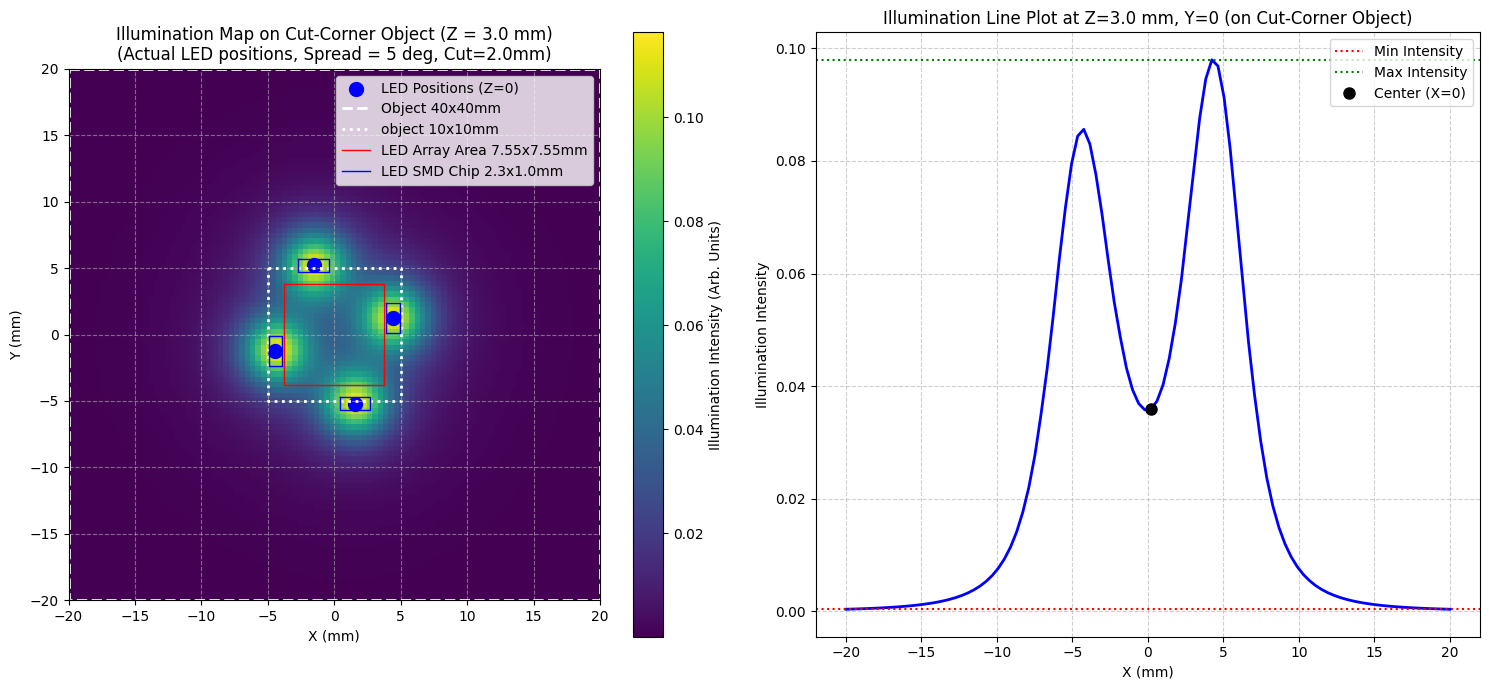


--- Illumination Statistics for Selected p_mm (Cut-Corner Object) ---
최대 조명 강도: 0.1163
최소 조명 강도: 0.0001
평균 조명 강도: 0.0084
조명 강도 표준 편차: 0.0188
균일성 (min/max): 0.0009

--- Line Plot Statistics for Selected p_mm (Y=0, on Cut-Corner Object) ---
라인 플롯 최대값: 0.0980
라인 플롯 최소값: 0.0004
라인 플롯 중점(X=0)에서의 값: 0.0359
라인 플롯 중점-최댓값 차이 (Center-Max Difference): 0.0621


In [21]:

## 메인 실행 블록 (주피터 노트북에서 각 함수를 호출하여 사용)
if __name__ == "__main__":
    # 고정된 파라미터 (최적화 및 플롯에 공통으로 사용될 값)
    common_params = {
        'target_z_mm': 3.00,
        'grid_dimension_mm':40.0, # 측정
        'simulation_resolution': 100, # 최적화 시 100, 최종 플롯 시 200 등으로 변경 가능
        'object_width_mm': 40,
        'object_height_mm': 40,
        'corner_cut_length_mm': 2.0,
        'passivation_spread_angle': 5
    }

    # # 최적화 파라미터 (p_mm) 설정
    # optimization_params = {
    #     'p_mm_min_val': 2.7 + 1.62/2,
    #     'p_mm_max_val': 5.5 - 1.62/2,
    #     'p_mm_step_val': 0.1,
    #     'max_no_improvement_tolerence': 2 # 조기 종료 횟수
    # }

    # print("Running optimization...")
    # optimized_results = run_optimization(
    #     **optimization_params,
    #     **common_params # common_params에 있는 모든 키-값 쌍을 인자로 전달
    # )

    # if optimized_results:
    #     print("\n--- Final Visualization for Optimal p_mm ---")
    #     plot_results(
    #         p_mm_to_plot=optimized_results['best_p_mm'],
    #         target_z_mm=common_params['target_z_mm'],
    #         grid_dimension_mm=common_params['grid_dimension_mm'],
    #         simulation_resolution=common_params['simulation_resolution'],
    #         object_width_mm=common_params['object_width_mm'],
    #         object_height_mm=common_params['object_height_mm'],
    #         corner_cut_length_mm=common_params['corner_cut_length_mm'],
    #         passivation_spread_angle=common_params['passivation_spread_angle']
    #     )

    # 주피터 노트북에서 개별적으로 호출하여 플롯을 확인하는 예시
    # 예를 들어, p=4.0mm 일 때의 플롯을 보고 싶다면:
    print("\n--- Custom Plot for z = 4.0mm ---")
    plot_results(
        # p_mm_to_plot=4.0,
        target_z_mm=common_params['target_z_mm'],
        grid_dimension_mm=common_params['grid_dimension_mm'],
        simulation_resolution=common_params['simulation_resolution'],
        object_width_mm=common_params['object_width_mm'],
        object_height_mm=common_params['object_height_mm'],
        corner_cut_length_mm=common_params['corner_cut_length_mm'],
        passivation_spread_angle=common_params['passivation_spread_angle']
    )

# 251019

       Fast Illumination Simulation Report
LED Configuration:
  - Layout: 4x4 grid with pitch 2.50 mm
  - Total LEDs: 12

ROI Analysis:
  - Working Distance: 6.00 mm
  - Total Power on ROI: 12.03 mW  (Target: > 34.0 mW)
  - Uniformity (min/max) in ROI: 0.506


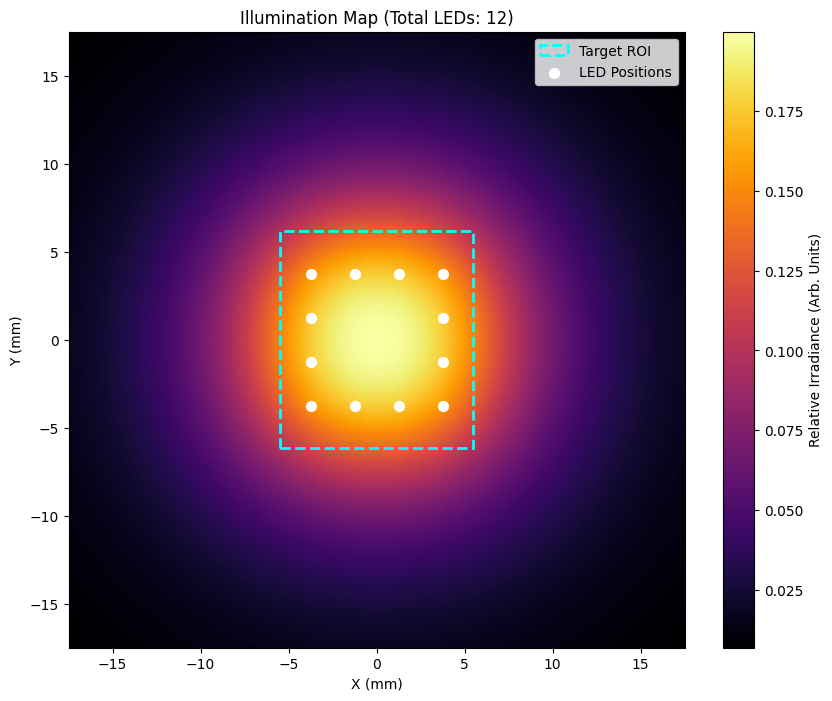

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import interp1d

# ==============================================================================
# 1. 시뮬레이션 파라미터 (여기만 수정하여 테스트)
# ==============================================================================
# --- 광학계 설정 ---
WORKING_DISTANCE_MM = 6.0
ROI_WIDTH_MM = 12.3
ROI_HEIGHT_MM = 11.0

# --- LED 배치 설정 ---
# 'ㅁ'자 형태의 배치를 위한 파라미터
# 예: 4x4 그리드에서 중앙 2x2를 비우면 총 12개의 LED가 'ㅁ'자로 배치됨
GRID_DIM = 4  # N x N 그리드 (예: 4x4, 5x5)
GRID_PITCH_MM = 2.5  # LED 간의 간격 (mm)
EXCLUDE_CENTER = True # True로 설정 시 중앙의 LED를 제외하여 'ㅁ'자 생성

# --- LED 특성 ---
# 데이터시트 기반 방사각 (수정 불필요)
LED_ANGLES_DEG = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
LED_INTENSITIES = np.array([1.0, 0.99, 0.98, 0.95, 0.90, 0.82, 0.70, 0.50, 0.25, 0.0])
# 실험 기반 단일 LED의 총 파워 (Raysect 보정값과 유사한 역할)
SINGLE_LED_TOTAL_POWER_MW = 3.02 # Raysect 단일 시뮬레이션 결과값으로 시작

# --- 시뮬레이션 정밀도 ---
RESOLUTION = 200  # 200x200 그리드
GRID_SIZE_MM = 35 # 관찰 영역 크기 (ROI보다 충분히 크게)

# ==============================================================================
# 2. 핵심 함수 (수정 불필요)
# ==============================================================================
def get_beam_profile_func(angles, intensities):
    """방사각 프로파일 보간 함수 생성"""
    f = interp1d(angles, intensities, kind='linear', fill_value=0.0, bounds_error=False)
    return f

def create_led_layout(grid_dim, pitch, exclude_center):
    """설정에 따라 LED 위치 배열 생성"""
    led_positions = []
    center_offset = (grid_dim - 1) * pitch / 2.0
    
    for i in range(grid_dim):
        for j in range(grid_dim):
            # 중앙 영역 제외 로직
            if exclude_center:
                is_center = (i > 0 and i < grid_dim - 1) and (j > 0 and j < grid_dim - 1)
                if is_center:
                    continue # 중앙 2x2 영역은 건너뜀
            
            x = i * pitch - center_offset
            y = j * pitch - center_offset
            led_positions.append(np.array([x, y, 0]))
            
    return led_positions

def simulate_illumination(led_positions, beam_profile_func, target_z, grid_size, resolution):
    """다중 LED 조명 시뮬레이션"""
    x = np.linspace(-grid_size / 2, grid_size / 2, resolution)
    y = np.linspace(-grid_size / 2, grid_size / 2, resolution)
    X, Y = np.meshgrid(x, y)
    
    illumination_map = np.zeros_like(X)
    
    for led_pos in led_positions:
        vectors_to_target = np.stack([X, Y, np.full_like(X, target_z)], axis=-1) - led_pos
        distances = np.linalg.norm(vectors_to_target, axis=-1)
        distances = np.where(distances == 0, 1e-9, distances) # 0으로 나누기 방지
        
        cos_theta = target_z / distances
        angle_degrees = np.degrees(np.arccos(np.clip(cos_theta, 0, 1)))
        
        # Lambert's Cosine Law: Irradiance ∝ (I(θ) * cos(θ)) / R^2
        # 데이터시트의 I(θ)는 이미 cos(θ) 효과가 반영된 광도(Intensity)이므로, cos(θ)를 한 번만 곱함
        intensity_contribution = beam_profile_func(angle_degrees) / (distances**2)
        illumination_map += intensity_contribution
        
    return X, Y, illumination_map

def analyze_roi(X, Y, illum_map, roi_w, roi_h, total_led_power_mw):
    """ROI 영역 분석: 총 파워 및 균일도 계산"""
    roi_mask = (np.abs(X) <= roi_w / 2) & (np.abs(Y) <= roi_h / 2)
    roi_illum = np.where(roi_mask, illum_map, np.nan)
    
    if np.all(np.isnan(roi_illum)):
        return 0, 0, 0, 0
    
    # 보정: 시뮬레이션 맵의 총합과 실제 총 파워를 비례시켜 스케일 팩터 계산
    sim_total_integral = np.sum(illum_map)
    real_total_power = total_led_power_mw
    scale_factor = real_total_power / sim_total_integral if sim_total_integral > 0 else 0
    
    # ROI 내 파워 계산
    roi_power_mw = np.nansum(roi_illum) * scale_factor
    
    # 균일도 계산 (Min/Max)
    min_val = np.nanmin(roi_illum)
    max_val = np.nanmax(roi_illum)
    uniformity = min_val / max_val if max_val > 0 else 0
    
    return roi_power_mw, uniformity, np.nanmean(roi_illum), np.nanstd(roi_illum)

# ==============================================================================
# 3. 메인 실행 및 시각화 (수정 불필요)
# ==============================================================================
if __name__ == "__main__":
    # 함수 실행
    beam_func = get_beam_profile_func(LED_ANGLES_DEG, LED_INTENSITIES)
    led_positions_mm = create_led_layout(GRID_DIM, GRID_PITCH_MM, EXCLUDE_CENTER)
    
    X_mm, Y_mm, illum_map_arb = simulate_illumination(
        led_positions_mm, beam_func, WORKING_DISTANCE_MM, GRID_SIZE_MM, RESOLUTION
    )
    
    # 분석
    total_power_all_leds = SINGLE_LED_TOTAL_POWER_MW * len(led_positions_mm)
    power_on_roi, uniformity_roi, mean_roi, std_roi = analyze_roi(
        X_mm, Y_mm, illum_map_arb, ROI_WIDTH_MM, ROI_HEIGHT_MM, total_power_all_leds
    )

    # 결과 출력
    print("="*50)
    print("       Fast Illumination Simulation Report")
    print("="*50)
    print(f"LED Configuration:")
    print(f"  - Layout: {GRID_DIM}x{GRID_DIM} grid with pitch {GRID_PITCH_MM:.2f} mm")
    print(f"  - Total LEDs: {len(led_positions_mm)}")
    print("\nROI Analysis:")
    print(f"  - Working Distance: {WORKING_DISTANCE_MM:.2f} mm")
    print(f"  - Total Power on ROI: {power_on_roi:.2f} mW  (Target: > 34.0 mW)")
    print(f"  - Uniformity (min/max) in ROI: {uniformity_roi:.3f}")
    print("="*50)
    
    # 시각화
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(illum_map_arb, extent=[-GRID_SIZE_MM/2, GRID_SIZE_MM/2, -GRID_SIZE_MM/2, GRID_SIZE_MM/2], cmap='inferno')
    
    # ROI 영역 표시
    roi_rect = patches.Rectangle(
        (-ROI_WIDTH_MM/2, -ROI_HEIGHT_MM/2), ROI_WIDTH_MM, ROI_HEIGHT_MM,
        linewidth=2, edgecolor='cyan', facecolor='none', linestyle='--', label='Target ROI'
    )
    ax.add_patch(roi_rect)
    
    # LED 위치 표시
    led_x = [pos[0] for pos in led_positions_mm]
    led_y = [pos[1] for pos in led_positions_mm]
    ax.scatter(led_x, led_y, c='white', marker='o', s=50, label='LED Positions')
    
    ax.set_title(f'Illumination Map (Total LEDs: {len(led_positions_mm)})')
    ax.set_xlabel('X (mm)'); ax.set_ylabel('Y (mm)'); ax.legend()
    fig.colorbar(im, ax=ax, label='Relative Irradiance (Arb. Units)')
    plt.show()

# LED chip 위치에 따른 차이   
카메라 센서가 쏘옥 들어가게 vs 카메라 앞에 조명 배치

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import interp1d

# ==============================================================================
# 1. 시뮬레이션 파라미터 (여기만 수정하여 테스트)
# ==============================================================================
# --- 시나리오 A: 평면형 (Planar) ---
WORKING_DISTANCE_MM = 5.0
# INNER_HOLE_RADIUS_MM = 4.0 
# NUM_LEDS = 12
# ARRAY_RADIUS_MM = 5.5 # LED가 배치될 원의 반지름
ROI_WIDTH_MM = 11.0
ROI_HEIGHT_MM = 12.3

# --- LED 배치 설정 ---
# 'ㅁ'자 형태의 배치를 위한 파라미터
# 예: 4x4 그리드에서 중앙 2x2를 비우면 총 12개의 LED가 'ㅁ'자로 배치됨
GRID_DIM = 4  # N x N 그리드 (예: 4x4, 5x5)
GRID_PITCH_MM = 2.5  # LED 간의 간격 (mm)
EXCLUDE_CENTER = True # True로 설정 시 중앙의 LED를 제외하여 'ㅁ'자 생성

# --- LED 특성 ---
# 데이터시트 기반 방사각 (수정 불필요)
LED_ANGLES_DEG = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
LED_INTENSITIES = np.array([1.0, 0.99, 0.98, 0.95, 0.90, 0.82, 0.70, 0.50, 0.25, 0.0])
# 실험 기반 단일 LED의 총 파워 (Raysect 보정값과 유사한 역할)
SINGLE_LED_TOTAL_POWER_MW = 3.02 # Raysect 단일 시뮬레이션 결과값으로 시작

# --- 시뮬레이션 정밀도 ---
RESOLUTION = 200  # 200x200 그리드
GRID_SIZE_MM = 35 # 관찰 영역 크기 (ROI보다 충분히 크게)

# ==============================================================================
# 2. 핵심 함수 (수정 불필요)
# ==============================================================================
def get_beam_profile_func(angles, intensities):
    """방사각 프로파일 보간 함수 생성"""
    f = interp1d(angles, intensities, kind='linear', fill_value=0.0, bounds_error=False)
    return f

def create_led_layout(grid_dim, pitch, exclude_center):
    """설정에 따라 LED 위치 배열 생성"""
    led_positions = []
    center_offset = (grid_dim - 1) * pitch / 2.0
    
    for i in range(grid_dim):
        for j in range(grid_dim):
            # 중앙 영역 제외 로직
            if exclude_center:
                is_center = (i > 0 and i < grid_dim - 1) and (j > 0 and j < grid_dim - 1)
                if is_center:
                    continue # 중앙 2x2 영역은 건너뜀
            
            x = i * pitch - center_offset
            y = j * pitch - center_offset
            led_positions.append(np.array([x, y, 0]))
            
    return led_positions

def simulate_illumination(led_positions, beam_profile_func, target_z, grid_size, resolution):
    """다중 LED 조명 시뮬레이션"""
    x = np.linspace(-grid_size / 2, grid_size / 2, resolution)
    y = np.linspace(-grid_size / 2, grid_size / 2, resolution)
    X, Y = np.meshgrid(x, y)
    
    illumination_map = np.zeros_like(X)
    
    for led_pos in led_positions:
        vectors_to_target = np.stack([X, Y, np.full_like(X, target_z)], axis=-1) - led_pos
        distances = np.linalg.norm(vectors_to_target, axis=-1)
        distances = np.where(distances == 0, 1e-9, distances) # 0으로 나누기 방지
        
        cos_theta = target_z / distances
        angle_degrees = np.degrees(np.arccos(np.clip(cos_theta, 0, 1)))
        
        # Lambert's Cosine Law: Irradiance ∝ (I(θ) * cos(θ)) / R^2
        # 데이터시트의 I(θ)는 이미 cos(θ) 효과가 반영된 광도(Intensity)이므로, cos(θ)를 한 번만 곱함
        intensity_contribution = beam_profile_func(angle_degrees) / (distances**2)
        illumination_map += intensity_contribution
        
    return X, Y, illumination_map

def analyze_roi(X, Y, illum_map, roi_w, roi_h, total_led_power_mw):
    """ROI 영역 분석: 총 파워 및 균일도 계산"""
    roi_mask = (np.abs(X) <= roi_w / 2) & (np.abs(Y) <= roi_h / 2)
    roi_illum = np.where(roi_mask, illum_map, np.nan)
    
    if np.all(np.isnan(roi_illum)):
        return 0, 0, 0, 0
    
    # 보정: 시뮬레이션 맵의 총합과 실제 총 파워를 비례시켜 스케일 팩터 계산
    sim_total_integral = np.sum(illum_map)
    real_total_power = total_led_power_mw
    scale_factor = real_total_power / sim_total_integral if sim_total_integral > 0 else 0
    
    # ROI 내 파워 계산
    roi_power_mw = np.nansum(roi_illum) * scale_factor
    
    # 균일도 계산 (Min/Max)
    min_val = np.nanmin(roi_illum)
    max_val = np.nanmax(roi_illum)
    uniformity = min_val / max_val if max_val > 0 else 0
    
    return roi_power_mw, uniformity, np.nanmean(roi_illum), np.nanstd(roi_illum)

# ==============================================================================
# 3. 메인 실행 및 시각화 (수정 불필요)
# ==============================================================================
if __name__ == "__main__":
    # 함수 실행
    beam_func = get_beam_profile_func(LED_ANGLES_DEG, LED_INTENSITIES)
    led_positions_mm = create_led_layout(GRID_DIM, GRID_PITCH_MM, EXCLUDE_CENTER)
    
    X_mm, Y_mm, illum_map_arb = simulate_illumination(
        led_positions_mm, beam_func, WORKING_DISTANCE_MM, GRID_SIZE_MM, RESOLUTION
    )
    
    # 분석
    total_power_all_leds = SINGLE_LED_TOTAL_POWER_MW * len(led_positions_mm)
    power_on_roi, uniformity_roi, mean_roi, std_roi = analyze_roi(
        X_mm, Y_mm, illum_map_arb, ROI_WIDTH_MM, ROI_HEIGHT_MM, total_power_all_leds
    )

    # 결과 출력
    print("="*50)
    print("       Fast Illumination Simulation Report")
    print("="*50)
    print(f"LED Configuration:")
    print(f"  - Layout: {GRID_DIM}x{GRID_DIM} grid with pitch {GRID_PITCH_MM:.2f} mm")
    print(f"  - Total LEDs: {len(led_positions_mm)}")
    print("\nROI Analysis:")
    print(f"  - Working Distance: {WORKING_DISTANCE_MM:.2f} mm")
    print(f"  - Total Power on ROI: {power_on_roi:.2f} mW  (Target: > 34.0 mW)")
    print(f"  - Uniformity (min/max) in ROI: {uniformity_roi:.3f}")
    print("="*50)
    
    # 시각화
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(illum_map_arb, extent=[-GRID_SIZE_MM/2, GRID_SIZE_MM/2, -GRID_SIZE_MM/2, GRID_SIZE_MM/2], cmap='inferno')
    
    # ROI 영역 표시
    roi_rect = patches.Rectangle(
        (-ROI_WIDTH_MM/2, -ROI_HEIGHT_MM/2), ROI_WIDTH_MM, ROI_HEIGHT_MM,
        linewidth=2, edgecolor='cyan', facecolor='none', linestyle='--', label='Target ROI'
    )
    ax.add_patch(roi_rect)
    
    # LED 위치 표시
    led_x = [pos[0] for pos in led_positions_mm]
    led_y = [pos[1] for pos in led_positions_mm]
    ax.scatter(led_x, led_y, c='white', marker='o', s=50, label='LED Positions')
    
    ax.set_title(f'Illumination Map (Total LEDs: {len(led_positions_mm)})')
    ax.set_xlabel('X (mm)'); ax.set_ylabel('Y (mm)'); ax.legend()
    fig.colorbar(im, ax=ax, label='Relative Irradiance (Arb. Units)')
    plt.show()

       Fast Illumination Simulation Report - SCENARIO [A]
Geometric Configuration:
  - LED Grid: 5x5 with 1.80 mm pitch
  - Cavity Size: 6.45 x 3.63 mm
  - Actual LED-to-Object Distance: 3.60 mm
  - Total LEDs Placed: 16

ROI Analysis:
  - Total Power on ROI: 29.60 mW  (Target: > 34.0 mW)
  - Uniformity (min/max) in ROI: 0.274


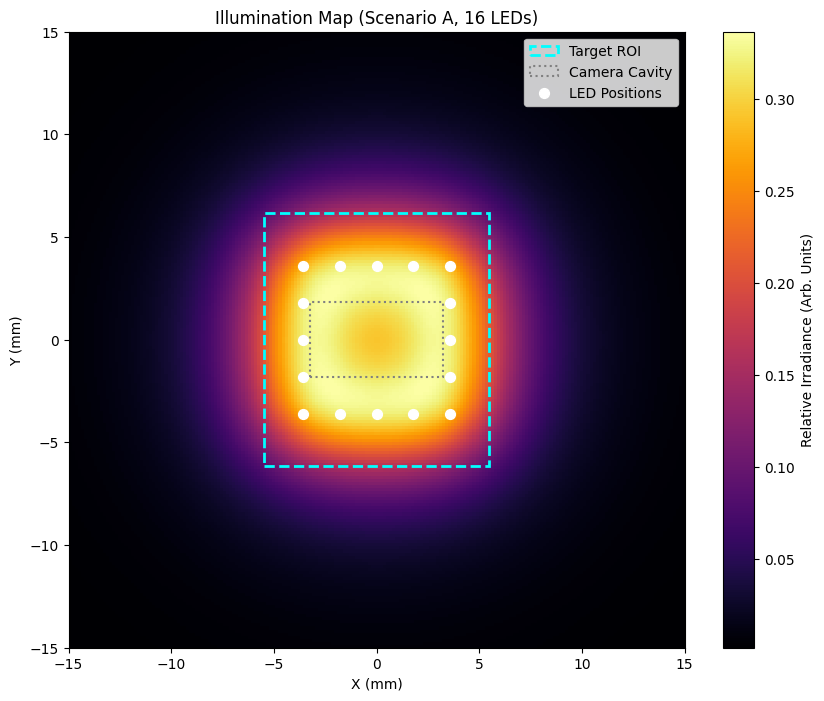

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import interp1d

# ======================================================================================
# 1. 시뮬레이션 파라미터 (여기만 수정하여 다양한 배치를 테스트합니다)
# ======================================================================================
# --- 시나리오 A: 평면형 배치 ---
PHASEMASK_TO_OBJECT_DISTANCE_MM = 6.0
LED_THICKNESS_MM = 2.3
OTHER_PARTS_THICKNESS_MM = 0.1

# --- 기구적 제약 조건 ---
CAVITY_WIDTH_MM = 6.45  # 카메라 센서 가로 크기
CAVITY_HEIGHT_MM = 3.63 # 카메라 센서 세로 크기
ROI_WIDTH_MM = 11.0
ROI_HEIGHT_MM = 12.3

# --- LED 배치 설정 ---
GRID_DIM_X = 5  # X축 방향 그리드 개수
GRID_DIM_Y = 5  # Y축 방향 그리드 개수
GRID_PITCH_MM = 1.8 # LED 간의 간격 (mm)

# --- LED 특성 ---
LED_ANGLES_DEG = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
LED_INTENSITIES = np.array([1.0, 0.99, 0.98, 0.95, 0.90, 0.82, 0.70, 0.50, 0.25, 0.0])
SINGLE_LED_TOTAL_POWER_MW = 3.02

# --- 시뮬레이션 정밀도 ---
RESOLUTION = 200
GRID_SIZE_MM = 30

# ======================================================================================
# 2. 핵심 함수 (상세 설명 포함)
# ======================================================================================

def get_beam_profile_func(angles, intensities):
    """
    [함수 설명]
    데이터시트의 방사각 데이터(점 데이터)를 바탕으로, 어떤 각도(angle)를 입력해도
    그에 해당하는 광도(intensity)를 알려주는 연속적인 함수를 생성합니다.

    [작동 원리]
    scipy의 interp1d는 주어진 점들 사이를 선형으로 연결(보간)하여 함수를 만듭니다.
    마치 꺾은선 그래프를 그리고, 그 선 위의 어떤 x값에 대한 y값을 읽는 것과 같습니다.
    - kind='linear': 점과 점 사이를 직선으로 연결합니다.
    - fill_value=0.0, bounds_error=False: 데이터 범위를 벗어나는 각도(예: 90도 이상)에 대해서는
      오류를 발생시키지 않고 광도를 0으로 처리합니다.
    """
    f = interp1d(angles, intensities, kind='linear', fill_value=0.0, bounds_error=False)
    return f

def create_led_layout(grid_dim_x, grid_dim_y, pitch, cavity_w, cavity_h):
    """
    [함수 설명]
    정의된 그리드와 중앙 구멍(Cavity) 크기에 맞춰 LED의 2D 좌표 목록을 생성합니다.
    구멍 내부에 위치하는 LED는 자동으로 배치에서 제외됩니다.

    [작동 원리]
    1. 전체 그리드의 중심을 (0,0)으로 맞추기 위해 center_offset을 계산합니다.
    2. 이중 for문을 통해 그리드 상의 모든 가능한 위치 (x, y)를 계산합니다.
    3. 각 (x, y) 좌표에 대해, |x|가 구멍 폭의 절반보다 작고, |y|가 구멍 높이의 절반보다
       작은지를 검사합니다.
    4. 만약 이 조건을 만족하면 (즉, LED가 구멍 안에 있으면), 해당 LED를 목록에 추가하지 않고
       건너뜁니다.
    5. 구멍 밖에 있는 유효한 LED들의 위치만 최종 목록으로 반환합니다.
    """
    led_positions = []
    offset_x = (grid_dim_x - 1) * pitch / 2.0
    offset_y = (grid_dim_y - 1) * pitch / 2.0
    
    for i in range(grid_dim_x):
        for j in range(grid_dim_y):
            x = i * pitch - offset_x
            y = j * pitch - offset_y
            
            # 중앙 구멍(Cavity) 내부에 있는지 확인하고, 해당되면 배치를 건너뜀
            if abs(x) < cavity_w / 2.0 and abs(y) < cavity_h / 2.0:
                continue
            
            # Z좌표는 0으로 고정 (LED 기판 평면)
            led_positions.append(np.array([x, y, 0]))
            
    return led_positions

def simulate_illumination(led_positions, beam_profile_func, target_z, grid_size, resolution):
    """
    [함수 설명]
    배치된 모든 LED가 목표 평면(ROI가 있는 곳)을 비출 때, 각 지점의 조도(irradiance)를
    계산하여 2D 맵을 생성합니다.

    [작동 원리]
    1. np.linspace와 np.meshgrid를 사용하여 목표 평면을 해상도(resolution)에 맞는
       촘촘한 격자(X, Y 좌표 행렬)로 나눕니다.
    2. 모든 LED에 대해 반복 계산을 수행합니다.
    3. 각 LED 위치(led_pos)에서 목표 평면의 모든 격자점(X, Y, target_z)까지의
       거리(distances)와 각도(angle_degrees)를 계산합니다.
    4. **물리 법칙 적용:** 각 격자점의 조도(irradiance)는 아래 법칙을 따릅니다.
       E = ( I(θ) * cos(θ) ) / r²
       - I(θ) [beam_profile_func]: LED의 방사각(θ)에 따른 빛의 세기 (광도)
       - 1/r² [distances**2]: 거리 제곱의 법칙. 거리가 멀어질수록 빛은 제곱에 반비례하여 약해집니다.
       - cos(θ) [cos_theta]: 램버트의 코사인 법칙. 빛이 표면에 비스듬히 입사할수록
         동일한 면적에 도달하는 에너지가 줄어드는 효과입니다.
    5. 각 LED에 의한 조도 기여분(intensity_contribution)을 모두 합산하여 최종
       조명 맵(illumination_map)을 완성합니다.
    """
    x_coords = np.linspace(-grid_size / 2, grid_size / 2, resolution)
    y_coords = np.linspace(-grid_size / 2, grid_size / 2, resolution)
    X, Y = np.meshgrid(x_coords, y_coords)
    
    total_illum_map = np.zeros_like(X)
    
    for led_pos in led_positions:
        # 각 픽셀에서 LED를 향하는 벡터 계산
        vectors_to_led = led_pos - np.stack([X, Y, np.full_like(X, target_z)], axis=-1)
        distances = np.linalg.norm(vectors_to_led, axis=-1)
        distances = np.where(distances == 0, 1e-9, distances)
        
        # LED의 법선(Z축)과 (LED->픽셀 벡터) 사이의 각도(theta)의 코사인 값 계산
        # LED가 (0,0,0)에 있고 아래(z>0)를 본다고 가정했을 때의 각도
        cos_theta = (target_z - led_pos[2]) / distances
        angle_degrees = np.degrees(np.arccos(np.clip(cos_theta, 0, 1)))
        
        # Irradiance 계산
        beam_intensity = beam_profile_func(angle_degrees)
        intensity_contribution = (beam_intensity * cos_theta) / (distances**2)
        total_illum_map += intensity_contribution
        
    return X, Y, total_illum_map

def analyze_roi(X, Y, illum_map, roi_w, roi_h, total_led_power_mw):
    """
    [함수 설명]
    계산된 전체 조명 맵에서 우리가 관심 있는 ROI 영역만 잘라내어,
    해당 영역의 총 파워(mW)와 균일도를 계산합니다.

    [작동 원리]
    1. ROI 마스크 생성: X, Y 좌표가 ROI 범위 안에 들어오는 픽셀만 True로 표시하는
       불리언 마스크(roi_mask)를 만듭니다.
    2. ROI 데이터 추출: 이 마스크를 이용해 조명 맵에서 ROI 영역의 조도 값만 추출하고,
       나머지는 계산에서 제외하기 위해 NaN(Not a Number)으로 처리합니다.
    3. 파워 보정(Calibration):
       - 시뮬레이션의 조도 맵은 상대적인 값입니다. 이를 실제 파워(mW)로 변환해야 합니다.
       - 모든 LED가 방출하는 실제 총 파워(total_led_power_mw)를, 시뮬레이션된 빛의
         총량(sim_total_integral)으로 나누어 '보정 계수(scale_factor)'를 구합니다.
       - 이 계수는 "시뮬레이션 값 1은 실제 몇 mW에 해당하는가?"를 의미합니다.
    4. 최종 파워 계산: ROI 영역의 시뮬레이션 조도 값들의 합에 보정 계수를 곱하여,
       ROI에 도달하는 실제 총 파워(roi_power_mw)를 계산합니다.
    5. 균일도 계산: ROI 내에서의 최소 조도 값을 최대 조도 값으로 나누어 균일도를 평가합니다.
       (1에 가까울수록 균일)
    """
    roi_mask = (np.abs(X) <= roi_w / 2) & (np.abs(Y) <= roi_h / 2)
    roi_illum = np.where(roi_mask, illum_map, np.nan)
    
    if np.all(np.isnan(roi_illum)): return 0, 0
    
    sim_total_integral = np.sum(illum_map)
    scale_factor = (total_led_power_mw / sim_total_integral) if sim_total_integral > 0 else 0
    
    roi_power_mw = np.nansum(roi_illum) * scale_factor
    uniformity = np.nanmin(roi_illum) / np.nanmax(roi_illum) if np.nanmax(roi_illum) > 0 else 0
    
    return roi_power_mw, uniformity

# ======================================================================================
# 5. 메인 실행 및 시각화
# ======================================================================================
if __name__ == "__main__":
    
    # 시나리오 A의 실제 LED-객체 간 거리 계산
    actual_led_object_distance = PHASEMASK_TO_OBJECT_DISTANCE_MM - OTHER_PARTS_THICKNESS_MM - LED_THICKNESS_MM

    # 함수 실행
    beam_func = get_beam_profile_func(LED_ANGLES_DEG, LED_INTENSITIES)
    led_positions_mm = create_led_layout(GRID_DIM_X, GRID_DIM_Y, GRID_PITCH_MM, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM)
    
    X_mm, Y_mm, illum_map_arb = simulate_illumination(
        led_positions_mm, beam_func, actual_led_object_distance, GRID_SIZE_MM, RESOLUTION
    )
    
    # 분석
    total_power_all_leds = SINGLE_LED_TOTAL_POWER_MW * len(led_positions_mm)
    power_on_roi, uniformity_roi = analyze_roi(
        X_mm, Y_mm, illum_map_arb, ROI_WIDTH_MM, ROI_HEIGHT_MM, total_power_all_leds
    )

    # 결과 출력
    print("="*60)
    print(f"       Fast Illumination Simulation Report - SCENARIO [A]")
    print("="*60)
    print(f"Geometric Configuration:")
    print(f"  - LED Grid: {GRID_DIM_X}x{GRID_DIM_Y} with {GRID_PITCH_MM:.2f} mm pitch")
    print(f"  - Cavity Size: {CAVITY_WIDTH_MM:.2f} x {CAVITY_HEIGHT_MM:.2f} mm")
    print(f"  - Actual LED-to-Object Distance: {actual_led_object_distance:.2f} mm")
    print(f"  - Total LEDs Placed: {len(led_positions_mm)}")
    
    print("\nROI Analysis:")
    print(f"  - Total Power on ROI: {power_on_roi:.2f} mW  (Target: > 34.0 mW)")
    print(f"  - Uniformity (min/max) in ROI: {uniformity_roi:.3f}")
    print("="*60)
    
    # 시각화
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(illum_map_arb, extent=[-GRID_SIZE_MM/2, GRID_SIZE_MM/2, -GRID_SIZE_MM/2, GRID_SIZE_MM/2], cmap='inferno')
    
    # ROI 영역 표시
    roi_rect = patches.Rectangle((-ROI_WIDTH_MM/2, -ROI_HEIGHT_MM/2), ROI_WIDTH_MM, ROI_HEIGHT_MM,
                                 linewidth=2, edgecolor='cyan', facecolor='none', linestyle='--', label='Target ROI')
    ax.add_patch(roi_rect)

    # Cavity 영역 표시
    cavity_rect = patches.Rectangle((-CAVITY_WIDTH_MM/2, -CAVITY_HEIGHT_MM/2), CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM,
                                 linewidth=1.5, edgecolor='gray', facecolor='none', linestyle=':', label='Camera Cavity')
    ax.add_patch(cavity_rect)
    
    # LED 위치 표시
    if led_positions_mm:
        led_x = [pos[0] for pos in led_positions_mm]
        led_y = [pos[1] for pos in led_positions_mm]
        ax.scatter(led_x, led_y, c='white', marker='o', s=50, label='LED Positions')
    
    ax.set_title(f'Illumination Map (Scenario A, {len(led_positions_mm)} LEDs)')
    ax.set_xlabel('X (mm)'); ax.set_ylabel('Y (mm)'); ax.legend()
    fig.colorbar(im, ax=ax, label='Relative Irradiance (Arb. Units)')
    plt.show()

       Fast Illumination Simulation Report - SCENARIO [A]
Geometric Configuration:
  - LED Grid: 5x5 with 1.80 mm pitch
  - Cavity Size (W x H): 6.45 x 3.63 mm
  - Actual LED-to-Object Distance: 3.60 mm
  - Total LEDs Placed: 16

ROI Analysis:
  - Target ROI Size (W x H): 11.00 x 12.30 mm
  - Total Power on ROI: 29.60 mW  (Target: > 34.0 mW)
  - Uniformity (min/max) in ROI: 0.274


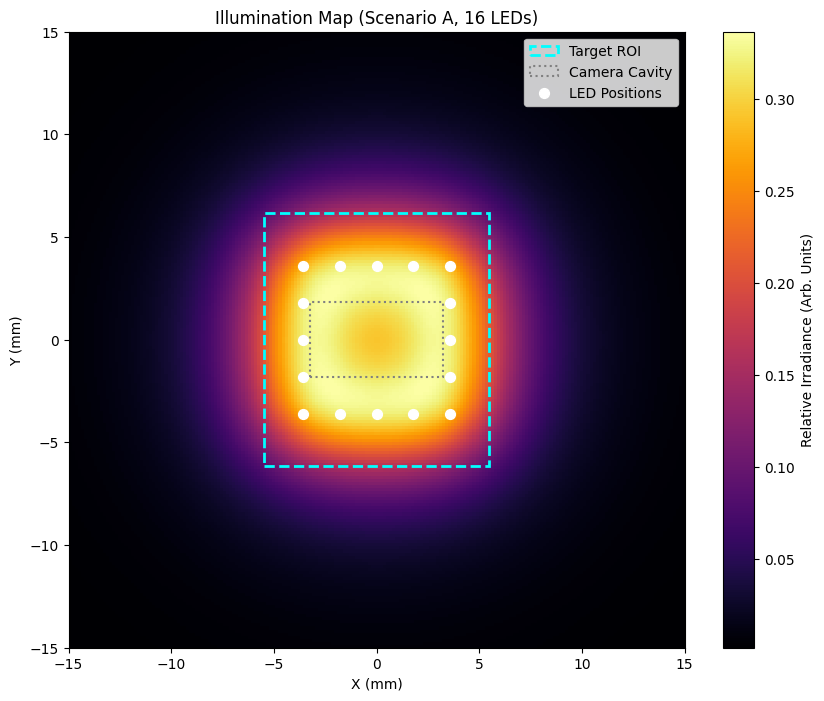

In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import interp1d

# ======================================================================================
# 1. 시뮬레이션 파라미터 (시나리오 A 기준)
# ======================================================================================
# --- 광학계 기본 설정 ---
PHASEMASK_TO_OBJECT_DISTANCE_MM = 6.0 # 페이즈마스크와 객체(치아) 사이의 거리 (mm)
ROI_WIDTH_MM = 11.0                   # 관심 영역(Region of Interest) 가로 크기 (mm)
ROI_HEIGHT_MM = 12.3                  # 관심 영역(Region of Interest) 세로 크기 (mm)

# --- 시나리오 A 기구적 수치 ---
LED_THICKNESS_MM = 2.3                # LED 칩의 두께 (mm)
OTHER_PARTS_THICKNESS_MM = 0.1        # 페이즈마스크+조리개 등 기타 부품 두께 합 (mm)
CAVITY_WIDTH_MM = 6.45                # 중앙 구멍 가로 크기 (mm) - 카메라 센서 크기
CAVITY_HEIGHT_MM = 3.63               # 중앙 구멍 세로 크기 (mm) - 카메라 센서 크기

# --- LED 배치 설정 ---
GRID_DIM_X = 5                        # X축 방향 가상 그리드 개수
GRID_DIM_Y = 5                        # Y축 방향 가상 그리드 개수
GRID_PITCH_MM = 1.8                   # 그리드 상 LED 간의 간격 (mm)

# --- LED 특성 ---
LED_ANGLES_DEG = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90]) # 데이터시트의 각도 (도)
LED_INTENSITIES = np.array([1.0, 0.99, 0.98, 0.95, 0.90, 0.82, 0.70, 0.50, 0.25, 0.0]) # 데이터시트의 상대 광도
SINGLE_LED_TOTAL_POWER_MW = 3.02      # 단일 LED 시뮬레이션 기반 총 파워 추정치 (mW) - 보정용

# --- 시뮬레이션 정밀도 ---
RESOLUTION = 200                      # 조명 맵 계산 해상도 (픽셀 수)
GRID_SIZE_MM = 30                     # 조명 맵 계산 영역 크기 (mm)

# ======================================================================================
# 2. 핵심 함수 (상세 설명 포함)
# ======================================================================================

def get_beam_profile_func(angles, intensities):
    """
    [함수 설명]
    데이터시트의 방사각(angles)과 각 각도에서의 상대 광도(intensities) 데이터를 받아,
    임의의 각도(degree)에 대한 상대 광도를 반환하는 보간 함수를 생성합니다.
    (데이터 포인트 사이의 값은 선형으로 추정합니다.)

    [Inputs]
    - angles (numpy array): 데이터시트의 각도 배열 (단위: 도). 예: [0, 10, 20, ..., 90]
    - intensities (numpy array): 각 각도에 해당하는 상대 광도 배열. 예: [1.0, 0.99, ..., 0.0]

    [Output]
    - function: 각도(도)를 입력받아 상대 광도(0~1)를 반환하는 함수.
    """
    # interp1d: 1차원 선형 보간 함수 생성
    # kind='linear': 점 사이를 직선으로 연결
    # fill_value=0.0: 입력 각도가 데이터 범위(0~90도)를 벗어나면 0을 반환 (빛 없음)
    # bounds_error=False: 범위 초과 시 오류 대신 fill_value 사용
    f = interp1d(angles, intensities, kind='linear', fill_value=0.0, bounds_error=False)
    return f

def create_led_layout(grid_dim_x, grid_dim_y, pitch, cavity_w, cavity_h):
    """
    [함수 설명]
    지정된 크기의 그리드(grid_dim_x, grid_dim_y)와 간격(pitch)으로 가상의 LED 위치를 생성하되,
    중앙의 카메라 구멍(cavity_w, cavity_h) 영역에 해당하는 LED는 배치에서 제외합니다.

    [Inputs]
    - grid_dim_x (int): X축 방향 그리드 칸 수.
    - grid_dim_y (int): Y축 방향 그리드 칸 수.
    - pitch (float): 그리드 칸 사이의 간격 (mm).
    - cavity_w (float): 중앙 구멍의 가로 크기 (mm).
    - cavity_h (float): 중앙 구멍의 세로 크기 (mm).

    [Output]
    - list of numpy arrays: 배치된 각 LED의 [x, y, z] 좌표 리스트 (단위: mm). Z좌표는 0으로 고정.
    """
    led_positions = []
    # 그리드의 중심을 (0,0)으로 맞추기 위한 오프셋 계산
    offset_x = (grid_dim_x - 1) * pitch / 2.0
    offset_y = (grid_dim_y - 1) * pitch / 2.0
    
    # 모든 그리드 위치를 순회
    for i in range(grid_dim_x):
        for j in range(grid_dim_y):
            # 현재 그리드 위치의 x, y 좌표 계산
            x = i * pitch - offset_x
            y = j * pitch - offset_y
            
            # 현재 위치가 중앙 구멍 내부에 있는지 확인
            # abs(x) < cavity_w / 2.0 : x좌표가 구멍의 좌우 경계 안에 있는지
            # abs(y) < cavity_h / 2.0 : y좌표가 구멍의 상하 경계 안에 있는지
            is_inside_cavity = abs(x) < cavity_w / 2.0 and abs(y) < cavity_h / 2.0
            
            # 구멍 내부에 있다면 이 위치는 건너뛰고 다음 위치로 이동
            if is_inside_cavity:
                continue
            
            # 구멍 외부에 있는 유효한 위치만 리스트에 추가 (Z좌표는 0)
            led_positions.append(np.array([x, y, 0]))
            
    return led_positions

def simulate_illumination(led_positions, beam_profile_func, target_z, grid_size, resolution):
    """
    [함수 설명]
    배치된 모든 LED(led_positions)가 목표 평면(z=target_z)에 만드는 조도(Irradiance) 분포를
    시뮬레이션하여 2D 맵으로 반환합니다.

    [Inputs]
    - led_positions (list): 각 LED의 [x, y, z] 좌표 리스트 (mm).
    - beam_profile_func (function): 각도(도)를 입력받아 상대 광도를 반환하는 함수.
    - target_z (float): 조도를 계산할 목표 평면의 Z 좌표 (mm).
    - grid_size (float): 조도 맵을 계산할 영역의 크기 (정사각형 가정, mm).
    - resolution (int): 조도 맵의 해상도 (가로/세로 픽셀 수).

    [Output]
    - X (numpy meshgrid): 조도 맵 각 픽셀의 X 좌표 (mm).
    - Y (numpy meshgrid): 조도 맵 각 픽셀의 Y 좌표 (mm).
    - total_illum_map (numpy array): 계산된 조도 맵 (상대 단위).
    """
    # 1. 목표 평면을 resolution x resolution 크기의 격자(grid)로 나눔
    x_coords = np.linspace(-grid_size / 2, grid_size / 2, resolution)
    y_coords = np.linspace(-grid_size / 2, grid_size / 2, resolution)
    X, Y = np.meshgrid(x_coords, y_coords) # X, Y는 각 격자점의 x, y 좌표를 담은 행렬

    # 최종 조도 맵을 저장할 배열 초기화 (모든 픽셀 값을 0으로)
    total_illum_map = np.zeros_like(X)
    
    # 배치된 모든 LED에 대해 반복 계산
    for led_pos in led_positions:
        # 2. 현재 LED 위치에서 목표 평면의 각 격자점까지의 벡터 계산
        #    - np.stack: X, Y 행렬과 Z좌표(target_z)를 합쳐 3차원 좌표 행렬 생성
        #    - led_pos - ... : 각 격자점에서 LED를 향하는 벡터 계산 (크기: resolution x resolution x 3)
        vectors_to_led = led_pos - np.stack([X, Y, np.full_like(X, target_z)], axis=-1)
        
        # 3. 각 벡터의 크기(거리) 계산
        distances = np.linalg.norm(vectors_to_led, axis=-1) # 각 픽셀과 LED 사이의 거리 행렬
        # 거리가 0이면 (LED 위치와 픽셀 위치가 같으면) 계산 오류 방지를 위해 아주 작은 값(1e-9)으로 대체
        distances = np.where(distances == 0, 1e-9, distances)
        
        # 4. LED 법선(Z축 방향)과 (LED->픽셀 벡터) 사이 각도의 코사인 값 계산
        #    - LED는 (led_pos[0], led_pos[1], led_pos[2])에 위치하고 Z축 양의 방향을 본다고 가정.
        #    - cos_theta = (Z축 방향 벡터) · (LED->픽셀 단위 벡터)
        #    - Z축 방향 벡터 = [0, 0, 1]
        #    - LED->픽셀 단위 벡터 = -vectors_to_led / distances
        #    - cos_theta = [0, 0, 1] · [-vectors_to_led_x/dist, -vectors_to_led_y/dist, -vectors_to_led_z/dist]
        #    - cos_theta = -vectors_to_led_z / distances = -(led_pos[2] - target_z) / distances
        #    - 여기서는 target_z가 LED의 z(0)보다 크므로 target_z - led_pos[2] = target_z > 0
        cos_theta = (target_z - led_pos[2]) / distances
        
        # 5. 코사인 값을 각도(degree)로 변환
        #    - np.clip: acos 함수는 입력값이 -1~1 범위여야 하므로, 범위를 벗어나는 값을 잘라냄
        angle_degrees = np.degrees(np.arccos(np.clip(cos_theta, 0, 1))) # 0~1 범위만 유효 (앞면만)
        
        # 6. Irradiance 계산: E = ( I(θ) * cos(θ) ) / r²
        #    - beam_profile_func(angle_degrees): 각도에 따른 상대 광도 I(θ)
        #    - cos_theta: 램버트 코사인 법칙 적용 (표면 입사각 효과)
        #    - distances**2: 역제곱 법칙 적용 (거리 효과)
        beam_intensity = beam_profile_func(angle_degrees)
        intensity_contribution = (beam_intensity * cos_theta) / (distances**2)
        
        # 7. 현재 LED에 의한 조도 기여분을 전체 맵에 더함
        total_illum_map += intensity_contribution
        
    return X, Y, total_illum_map

def analyze_roi(X, Y, illum_map, roi_w, roi_h, total_led_power_mw):
    """
    [함수 설명]
    계산된 전체 조명 맵(illum_map)에서 관심 영역(ROI)만 분석하여,
    해당 영역의 총 파워(mW)와 균일도(최소/최대 조도 비율)를 계산합니다.

    [Inputs]
    - X, Y (numpy meshgrid): 조도 맵 각 픽셀의 X, Y 좌표 (mm).
    - illum_map (numpy array): 시뮬레이션된 조도 맵 (상대 단위).
    - roi_w (float): ROI 가로 크기 (mm).
    - roi_h (float): ROI 세로 크기 (mm).
    - total_led_power_mw (float): 시뮬레이션에 사용된 모든 LED의 실제 총 파워 합 (mW).

    [Output]
    - roi_power_mw (float): ROI 영역에 도달하는 총 파워 (mW).
    - uniformity (float): ROI 영역 내 균일도 (최소 조도 / 최대 조도).
    """
    # 1. ROI 영역 마스크 생성
    #    X, Y 좌표가 ROI 경계 내에 있는 픽셀만 True 값을 가짐
    roi_mask = (np.abs(X) <= roi_w / 2) & (np.abs(Y) <= roi_h / 2)
    
    # 2. 마스크를 이용해 ROI 영역 데이터만 추출
    #    np.where(조건, 참일때 값, 거짓일때 값)
    #    ROI 내부 픽셀은 원래 조도 값을 유지하고, 외부는 NaN(계산 제외 대상)으로 설정
    roi_illum = np.where(roi_mask, illum_map, np.nan)
    
    # ROI 내에 유효한 데이터가 전혀 없는 경우 0 반환
    if np.all(np.isnan(roi_illum)): return 0, 0
    
    # 3. 파워 보정 계수 계산
    #    시뮬레이션 조도 맵 전체의 합 (모든 픽셀의 상대 조도 합) 계산
    sim_total_integral = np.sum(illum_map[~np.isnan(illum_map)]) # NaN 값 제외하고 합산
    # 실제 총 파워를 시뮬레이션 총 합으로 나누어, 상대 단위 1이 몇 mW에 해당하는지 계산
    scale_factor = (total_led_power_mw / sim_total_integral) if sim_total_integral > 0 else 0
    
    # 4. ROI 총 파워 계산
    #    ROI 영역 내 픽셀들의 상대 조도 합(np.nansum)에 보정 계수를 곱함
    roi_power_mw = np.nansum(roi_illum) * scale_factor
    
    # 5. 균일도 계산
    min_val = np.nanmin(roi_illum) # ROI 내 최소 조도
    max_val = np.nanmax(roi_illum) # ROI 내 최대 조도
    # 최소값을 최대값으로 나누어 균일도 계산 (0~1 사이 값)
    uniformity = min_val / max_val if max_val > 0 else 0
    
    return roi_power_mw, uniformity

# ======================================================================================
# 5. 메인 실행 및 시각화
# ======================================================================================
if __name__ == "__main__":
    
    # 시나리오 A의 실제 LED 기판과 객체(치아) 사이의 거리 계산
    actual_led_object_distance = PHASEMASK_TO_OBJECT_DISTANCE_MM - OTHER_PARTS_THICKNESS_MM - LED_THICKNESS_MM

    # ---- 함수 실행 ----
    # 1. 방사각 프로파일 함수 생성
    beam_func = get_beam_profile_func(LED_ANGLES_DEG, LED_INTENSITIES)
    # 2. LED 배치 좌표 생성 (카메라 구멍 고려)
    led_positions_mm = create_led_layout(GRID_DIM_X, GRID_DIM_Y, GRID_PITCH_MM, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM)
    # 3. 조명 시뮬레이션 실행
    X_mm, Y_mm, illum_map_arb = simulate_illumination(
        led_positions_mm, beam_func, actual_led_object_distance, GRID_SIZE_MM, RESOLUTION
    )
    
    # ---- 결과 분석 ----
    # 시뮬레이션에 사용된 모든 LED의 실제 총 파워 계산
    total_power_all_leds = SINGLE_LED_TOTAL_POWER_MW * len(led_positions_mm)
    # ROI 영역 분석 (총 파워, 균일도 계산)
    power_on_roi, uniformity_roi = analyze_roi(
        X_mm, Y_mm, illum_map_arb, ROI_WIDTH_MM, ROI_HEIGHT_MM, total_power_all_leds
    )

    # ---- 결과 출력 ----
    print("="*60)
    print(f"       Fast Illumination Simulation Report - SCENARIO [A]")
    print("="*60)
    print(f"Geometric Configuration:")
    print(f"  - LED Grid: {GRID_DIM_X}x{GRID_DIM_Y} with {GRID_PITCH_MM:.2f} mm pitch")
    print(f"  - Cavity Size (W x H): {CAVITY_WIDTH_MM:.2f} x {CAVITY_HEIGHT_MM:.2f} mm")
    print(f"  - Actual LED-to-Object Distance: {actual_led_object_distance:.2f} mm")
    print(f"  - Total LEDs Placed: {len(led_positions_mm)}")
    
    print("\nROI Analysis:")
    print(f"  - Target ROI Size (W x H): {ROI_WIDTH_MM:.2f} x {ROI_HEIGHT_MM:.2f} mm")
    print(f"  - Total Power on ROI: {power_on_roi:.2f} mW  (Target: > 34.0 mW)")
    print(f"  - Uniformity (min/max) in ROI: {uniformity_roi:.3f}")
    print("="*60)
    
    # ---- 결과 시각화 ----
    fig, ax = plt.subplots(figsize=(10, 8)) # 그래프를 그릴 도화지(fig)와 축(ax) 생성

    # 1. 2D 조도 맵 그리기 (imshow)
    #    - illum_map_arb: 시뮬레이션 결과인 2D 조도 배열
    #    - extent: 이미지의 좌표축 범위를 실제 물리적 크기(mm)로 설정 [-15, 15, -15, 15]
    #    - cmap='inferno': 밝을수록 노란색, 어두울수록 보라색으로 표시하는 컬러맵
    im = ax.imshow(illum_map_arb, extent=[-GRID_SIZE_MM/2, GRID_SIZE_MM/2, -GRID_SIZE_MM/2, GRID_SIZE_MM/2], cmap='inferno', origin='lower')
    
    # 2. ROI 영역 경계선 그리기 (파란색 점선 사각형)
    roi_rect = patches.Rectangle(
        (-ROI_WIDTH_MM/2, -ROI_HEIGHT_MM/2), # 사각형의 좌측 하단 꼭짓점 좌표
        ROI_WIDTH_MM,                       # 사각형의 가로 길이
        ROI_HEIGHT_MM,                      # 사각형의 세로 길이
        linewidth=2, edgecolor='cyan', facecolor='none', linestyle='--', label='Target ROI'
    )
    ax.add_patch(roi_rect) # 생성된 사각형을 축에 추가

    # 3. 카메라 구멍(Cavity) 영역 경계선 그리기 (회색 점선 사각형)
    cavity_rect = patches.Rectangle(
        (-CAVITY_WIDTH_MM/2, -CAVITY_HEIGHT_MM/2), CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM,
        linewidth=1.5, edgecolor='gray', facecolor='none', linestyle=':', label='Camera Cavity'
    )
    ax.add_patch(cavity_rect)
    
    # 4. 배치된 LED 위치 표시 (흰색 원)
    if led_positions_mm: # LED가 하나라도 배치되었으면
        led_x = [pos[0] for pos in led_positions_mm] # 모든 LED의 x 좌표 추출
        led_y = [pos[1] for pos in led_positions_mm] # 모든 LED의 y 좌표 추출
        ax.scatter(led_x, led_y, c='white', marker='o', s=50, label='LED Positions') # 점 찍기
    
    # 5. 그래프 제목 및 축 레이블 설정
    ax.set_title(f'Illumination Map (Scenario A, {len(led_positions_mm)} LEDs)')
    ax.set_xlabel('X (mm)'); ax.set_ylabel('Y (mm)')
    ax.legend() # 범례 표시 (ROI, Cavity, LED Positions)
    
    # 6. 컬러바 추가
    #    색상 스케일이 실제 어떤 조도 값(상대 단위)에 해당하는지 표시
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Relative Irradiance (Arb. Units)')
    
    plt.show() # 최종 그래프 화면에 표시

real 4 led value

--- Running in Calibration Mode (Precise 4 LEDs) ---
  - Using precise coordinates for 4 LEDs.

Calibration Results:
  - Simulated Power (4 LEDs, Initial): 6.35 mW
  - Experimental Power (4 LEDs): 34.00 mW
  - Calibration Factor: 5.357
  >>> Calibrated SINGLE_LED_TOTAL_POWER_MW: 16.180 mW <<<

NOTE: Set CALIBRATION_MODE = False and update SINGLE_LED_TOTAL_POWER_MW
      with the calibrated value (16.180 mW) to run the actual simulation.


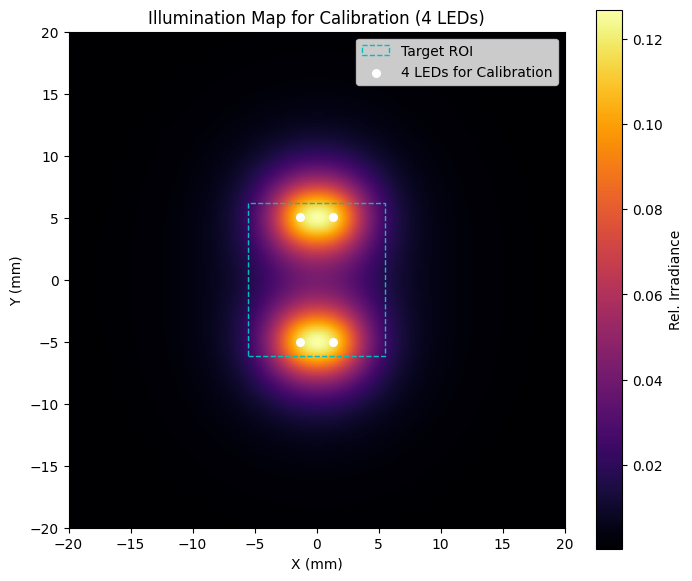

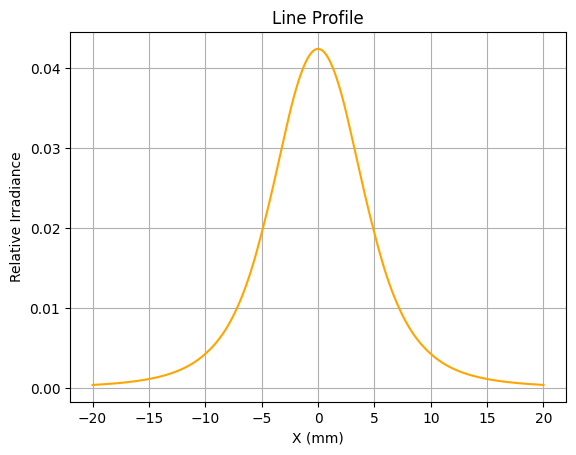


--- Plotting Diagonal Line Profile for Calibration (4 LEDs) ---


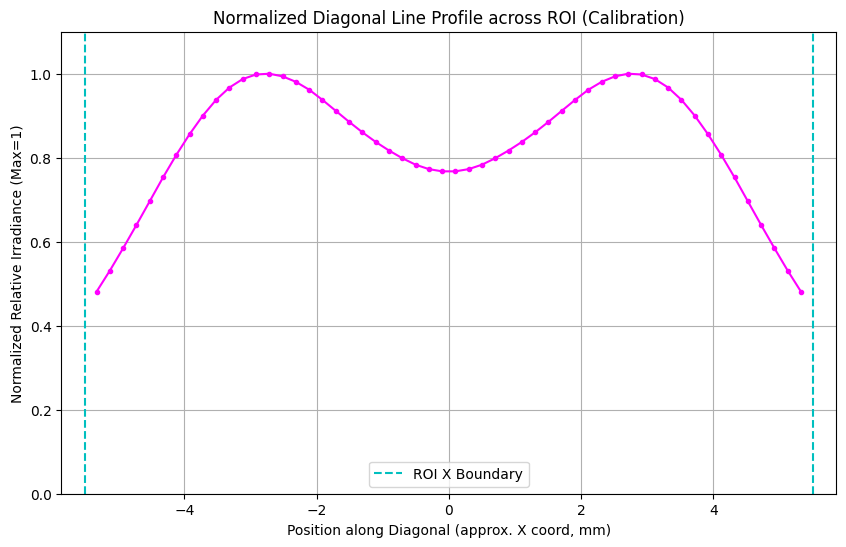

In [41]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import interp1d
import pandas as pd
from datetime import datetime

# ======================================================================================
# 1. 시뮬레이션 파라미터
# ======================================================================================
# --- 보정 모드 설정 ---
CALIBRATION_MODE = True # True: 보정 실행 / False: 실제 시뮬레이션 실행
EXPERIMENTAL_POWER_4LED_MW = 34.0

# --- 광학계 기본 설정 ---
PHASEMASK_TO_OBJECT_DISTANCE_MM = 6.0
ROI_WIDTH_MM = 11.0
ROI_HEIGHT_MM = 12.3

# --- 시나리오 A 기구적 수치 ---
LED_THICKNESS_MM = 2.3
OTHER_PARTS_THICKNESS_MM = 0.1
CAVITY_WIDTH_MM = 6.45
CAVITY_HEIGHT_MM = 3.63

# --- LED 배치 설정 ---
GRID_DIM_X = 5
GRID_DIM_Y = 5
GRID_PITCH_MM = 1.8

# --- LED 특성 ---
LED_ANGLES_DEG = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
LED_INTENSITIES = np.array([1.0, 0.99, 0.98, 0.95, 0.90, 0.82, 0.70, 0.50, 0.25, 0.0])
INITIAL_SINGLE_LED_POWER_MW = 3.02
# ✨ 보정 후 이 값을 업데이트 하세요 (예: 9.78) ✨
SINGLE_LED_TOTAL_POWER_MW = 15.832 # INITIAL_SINGLE_LED_POWER_MW

# --- 시뮬레이션 정밀도 ---
RESOLUTION = 200
GRID_SIZE_MM = 40
MM_PER_M = 1000.0 # 단위 변환 계수

# ======================================================================================
# 2. 핵심 함수 (analyze_roi 반환값 수정)
# ======================================================================================
def get_beam_profile_func(angles, intensities):
    f = interp1d(angles, intensities, kind='linear', fill_value=0.0, bounds_error=False)
    return f

def create_led_layout(grid_dim_x, grid_dim_y, pitch, cavity_w, cavity_h):
    led_positions = []
    offset_x = (grid_dim_x - 1) * pitch / 2.0; offset_y = (grid_dim_y - 1) * pitch / 2.0
    for i in range(grid_dim_x):
        for j in range(grid_dim_y):
            x = i * pitch - offset_x; y = j * pitch - offset_y
            if abs(x) < cavity_w / 2.0 and abs(y) < cavity_h / 2.0: continue
            led_positions.append(np.array([x, y, 0]))
    return led_positions

def create_4_led_layout_precise(a=1.34, b=5.06):
    led_positions = [np.array([a, b, 0]), np.array([-a, b, 0]), np.array([-a, -b, 0]), np.array([a, -b, 0])]
    return led_positions

def simulate_illumination(led_positions, beam_profile_func, target_z, grid_size, resolution):
    x_coords = np.linspace(-grid_size / 2, grid_size / 2, resolution); y_coords = np.linspace(-grid_size / 2, grid_size / 2, resolution)
    X, Y = np.meshgrid(x_coords, y_coords)
    total_illum_map = np.zeros_like(X)
    for led_pos in led_positions:
        vectors_to_led = led_pos - np.stack([X, Y, np.full_like(X, target_z)], axis=-1)
        distances = np.linalg.norm(vectors_to_led, axis=-1); distances = np.where(distances == 0, 1e-9, distances)
        cos_theta = (target_z - led_pos[2]) / distances
        angle_degrees = np.degrees(np.arccos(np.clip(cos_theta, 0, 1)))
        beam_intensity = beam_profile_func(angle_degrees)
        intensity_contribution = (beam_intensity * cos_theta) / (distances**2)
        total_illum_map += intensity_contribution
    return X, Y, total_illum_map

def analyze_roi(X, Y, illum_map, roi_w, roi_h, effective_single_led_power_mw, num_leds):
    """ ROI 분석: 총 파워(mW), 균일도, 스케일 팩터 계산 """
    roi_mask = (np.abs(X) <= roi_w / 2) & (np.abs(Y) <= roi_h / 2)
    roi_illum = np.where(roi_mask, illum_map, np.nan)
    if np.all(np.isnan(roi_illum)): return 0, 0, 0.0

    # 시뮬레이션 영역의 픽셀 당 면적 계산 (mm^2)  
    dx = X[0, 1] - X[0, 0]
    dy = Y[1, 0] - Y[0, 0]
    pixel_area_mm2 = dx * dy

    # 상대 조도 맵 전체의 적분값 (Arb Unit * mm^2)
    sim_total_integral = np.sum(illum_map[~np.isnan(illum_map)]) * pixel_area_mm2
    
    total_led_power_mw_reference = effective_single_led_power_mw * num_leds
    
    # 스케일 팩터 계산 (mW / (Arb Unit * mm^2))
    scale_factor = (total_led_power_mw_reference / sim_total_integral) if sim_total_integral > 0 else 0.0
    
    # ROI 총 파워 계산 (mW)
    # ROI 내 상대 조도 합 * 픽셀 면적 * 스케일 팩터
    roi_power_mw = np.nansum(roi_illum) * pixel_area_mm2 * scale_factor
    
    uniformity = np.nanmin(roi_illum) / np.nanmax(roi_illum) if np.nanmax(roi_illum) > 0 else 0
    
    # [수정] scale_factor를 반환하여 외부에서 절대 조도 맵 계산에 사용
    return roi_power_mw, uniformity, scale_factor

# ======================================================================================
# 3. 로그 기록 함수
# ======================================================================================
def log_simulation_result(log_file, data):
    try: df = pd.read_csv(log_file)
    except FileNotFoundError: df = pd.DataFrame(columns=data.keys())
    new_log = pd.DataFrame([data]); df = pd.concat([df, new_log], ignore_index=True)
    df.to_csv(log_file, index=False); print(f"\n✅ Simulation result logged to '{log_file}'")

# ======================================================================================
# 4. 메인 실행 및 시각화
# ======================================================================================
if __name__ == "__main__":
    
    actual_led_object_distance = PHASEMASK_TO_OBJECT_DISTANCE_MM - OTHER_PARTS_THICKNESS_MM - LED_THICKNESS_MM
    beam_func = get_beam_profile_func(LED_ANGLES_DEG, LED_INTENSITIES)

    if CALIBRATION_MODE:
        # (보정 모드 코드는 이전과 동일)
        print("--- Running in Calibration Mode (Precise 4 LEDs) ---")
        led_positions_calib = create_4_led_layout_precise(a=1.34, b=5.06); num_leds_calib = len(led_positions_calib)
        print(f"  - Using precise coordinates for {num_leds_calib} LEDs.")
        X_mm, Y_mm, illum_map_calib = simulate_illumination(led_positions_calib, beam_func, actual_led_object_distance, GRID_SIZE_MM, RESOLUTION)
        power_calib, uniformity_calib, scale_factor_for_calib_power = analyze_roi(X_mm, Y_mm, illum_map_calib, ROI_WIDTH_MM, ROI_HEIGHT_MM, INITIAL_SINGLE_LED_POWER_MW, num_leds_calib)
        calibration_factor = EXPERIMENTAL_POWER_4LED_MW / power_calib if power_calib > 0 else 1.0
        calibrated_single_led_power = INITIAL_SINGLE_LED_POWER_MW * calibration_factor
        print(f"\nCalibration Results:"); print(f"  - Simulated Power (4 LEDs, Initial): {power_calib:.2f} mW"); print(f"  - Experimental Power (4 LEDs): {EXPERIMENTAL_POWER_4LED_MW:.2f} mW"); print(f"  - Calibration Factor: {calibration_factor:.3f}"); print(f"  >>> Calibrated SINGLE_LED_TOTAL_POWER_MW: {calibrated_single_led_power:.3f} mW <<<")
        print("\nNOTE: Set CALIBRATION_MODE = False and update SINGLE_LED_TOTAL_POWER_MW"); print(f"      with the calibrated value ({calibrated_single_led_power:.3f} mW) to run the actual simulation.")
        fig_calib, ax_calib = plt.subplots(figsize=(8, 7)); im_calib = ax_calib.imshow(illum_map_calib, extent=[-GRID_SIZE_MM/2, GRID_SIZE_MM/2, -GRID_SIZE_MM/2, GRID_SIZE_MM/2], cmap='inferno', origin='lower'); roi_rect_calib = patches.Rectangle((-ROI_WIDTH_MM/2, -ROI_HEIGHT_MM/2), ROI_WIDTH_MM, ROI_HEIGHT_MM, lw=1, ec='c', fc='none', ls='--', label='Target ROI'); ax_calib.add_patch(roi_rect_calib); led_x_calib = [pos[0] for pos in led_positions_calib]; led_y_calib = [pos[1] for pos in led_positions_calib]; ax_calib.scatter(led_x_calib, led_y_calib, c='w', marker='o', s=30, label='4 LEDs for Calibration'); ax_calib.set_title('Illumination Map for Calibration (4 LEDs)'); ax_calib.set_xlabel('X (mm)'); ax_calib.set_ylabel('Y (mm)'); ax_calib.legend(); fig_calib.colorbar(im_calib, ax=ax_calib, label='Rel. Irradiance'); plt.show()
        
        # 조도 맵의 y축 가운데 인덱스 계산
        center_y_index = illum_map_calib.shape[0] // 2

        # 해당 y 위치에서 x축 방향의 조도 값 추출
        line_data = illum_map_calib[center_y_index, :]

        # x축 좌표 생성 (extent_mm 기준)
        x_min, x_max = -GRID_SIZE_MM/2, GRID_SIZE_MM/2
        x_coords = np.linspace(x_min, x_max, illum_map_arb.shape[1])

        figL, axL = plt.subplots()
        axL.plot(x_coords, line_data, color='orange')
        axL.set_title('Line Profile')
        axL.set_xlabel('X (mm)')
        axL.set_ylabel('Relative Irradiance')
        axL.grid(True)
        plt.show()
        
        # --- ✨ NEW! ✨ Calibration 모드용 대각선 라인 플롯 추가 ---
        print("\n--- Plotting Diagonal Line Profile for Calibration (4 LEDs) ---")

        # 1. 조도 맵에서 대각선 픽셀 인덱스 찾기 (좌하단 -> 우상단)
        diag_indices_calib = np.arange(RESOLUTION)
        # 보정 맵(illum_map_calib)에서 대각선 데이터 추출 (상대 조도)
        diagonal_data_calib_arb = illum_map_calib.diagonal()

        # 2. 대각선 상의 X 좌표 계산 (mm 단위)
        x_diag_calib = np.linspace(-GRID_SIZE_MM / 2, GRID_SIZE_MM / 2, RESOLUTION)

        # 3. ROI 영역에 해당하는 데이터만 필터링 (X좌표 기준 근사)
        #    (정확한 대각선 ROI 필터링은 더 복잡하므로 X좌표 기준으로 근사합니다)
        roi_diag_mask_calib = (np.abs(x_diag_calib) <= ROI_WIDTH_MM / 2)
        x_diag_roi_calib = x_diag_calib[roi_diag_mask_calib]
        diag_data_roi_calib_arb = diagonal_data_calib_arb[roi_diag_mask_calib]
        
        
        # --- ✨ 여기가 추가된 정규화 로직 ✨ ---
        # 4. 데이터 정규화 (최댓값으로 나누기)
        if len(diag_data_roi_calib_arb) > 0:
            max_val_calib = np.nanmax(diag_data_roi_calib_arb) # ROI 내 대각선 데이터의 최댓값
            if max_val_calib > 0:
                # 최댓값이 0보다 클 때만 정규화 수행
                diag_data_roi_calib_normalized = diag_data_roi_calib_arb / max_val_calib
            else:
                # 최댓값이 0이면 (모든 값이 0), 정규화 결과도 0으로 설정
                diag_data_roi_calib_normalized = diag_data_roi_calib_arb
        else:
            diag_data_roi_calib_normalized = [] # 데이터가 없으면 빈 리스트

        # 5. 라인 플롯 생성 (정규화된 데이터 사용)
        if len(x_diag_roi_calib) > 0 and len(diag_data_roi_calib_normalized) > 0 :
            fig_diag_calib, ax_diag_calib = plt.subplots(figsize=(10, 6))
            # [수정] 정규화된 데이터(diag_data_roi_calib_normalized)를 플롯
            ax_diag_calib.plot(x_diag_roi_calib, diag_data_roi_calib_normalized, marker='.', linestyle='-', color='magenta')
            ax_diag_calib.set_title(f'Normalized Diagonal Line Profile across ROI (Calibration)')
            ax_diag_calib.set_xlabel('Position along Diagonal (approx. X coord, mm)')
            # [수정] Y축 레이블 변경
            ax_diag_calib.set_ylabel('Normalized Relative Irradiance (Max=1)')
            ax_diag_calib.set_ylim(0, 1.1) # Y축 범위를 0~1.1로 고정하여 비교 용이
            ax_diag_calib.grid(True)
            ax_diag_calib.axvline(-ROI_WIDTH_MM/2, color='c', linestyle='--', label='ROI X Boundary')
            ax_diag_calib.axvline(ROI_WIDTH_MM/2, color='c', linestyle='--')
            ax_diag_calib.legend()
            plt.show()
        else:
            print("No data points found along the diagonal within the ROI for calibration.")
        # --- 대각선 라인 플롯 끝 ---
        
    else:
        # --- 시뮬레이션 모드 ---
        print("--- Running in Simulation Mode ---")
        led_positions_mm = create_led_layout(GRID_DIM_X, GRID_DIM_Y, GRID_PITCH_MM, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM)
        num_leds_sim = len(led_positions_mm)
        if SINGLE_LED_TOTAL_POWER_MW == INITIAL_SINGLE_LED_POWER_MW: print("\nWARNING: Update SINGLE_LED_TOTAL_POWER_MW with calibrated value.");
        
        # 시뮬레이션 실행
        start_time = datetime.now()
        X_mm, Y_mm, illum_map_arb = simulate_illumination(led_positions_mm, beam_func, actual_led_object_distance, GRID_SIZE_MM, RESOLUTION)
        end_time = datetime.now()
        print(f"Simulation finished. Elapsed time: {end_time - start_time}")

        # ROI 분석 (파워, 균일도, 스케일 팩터 계산)
        power_on_roi, uniformity_roi, scale_factor = analyze_roi(X_mm, Y_mm, illum_map_arb, ROI_WIDTH_MM, ROI_HEIGHT_MM, SINGLE_LED_TOTAL_POWER_MW, num_leds_sim)

        # ✨ NEW! ✨ 절대 조도 맵 계산 (W/m^2 단위)
        # scale_factor 단위: mW / (Arb Unit * mm^2)
        # W/m^2 로 변환 계수: (1 W / 1000 mW) * (1000 mm / 1 m)^2 = 1000
        irradiance_map_W_m2 = illum_map_arb * scale_factor * (MM_PER_M**2 / 1000.0)

        # 결과 출력
        mean_irradiance_on_roi_W_m2 = power_on_roi / (ROI_WIDTH_MM * ROI_HEIGHT_MM / MM_PER_M**2 * 1000.0) # mW / mm^2 -> W/m^2
        print("="*60); print(f"       Fast Illumination Simulation Report - SCENARIO [A]"); print("="*60); print(f"Geometric Configuration:"); print(f"  - LED Grid: {GRID_DIM_X}x{GRID_DIM_Y} with {GRID_PITCH_MM:.2f} mm pitch"); print(f"  - Cavity Size (W x H): {CAVITY_WIDTH_MM:.2f} x {CAVITY_HEIGHT_MM:.2f} mm"); print(f"  - Actual LED-to-Object Distance: {actual_led_object_distance:.2f} mm"); print(f"  - Total LEDs Placed: {num_leds_sim}")
        print("\nROI Analysis:"); print(f"  - Target ROI Size (W x H): {ROI_WIDTH_MM:.2f} x {ROI_HEIGHT_MM:.2f} mm"); print(f"  - Total Power on ROI: {power_on_roi:.2f} mW  (Target: > 34.0 mW)"); print(f"  - Mean Irradiance on ROI: {mean_irradiance_on_roi_W_m2:.2f} W/m^2"); print(f"  - Uniformity (min/max) in ROI: {uniformity_roi:.3f}"); print("="*60)

        # 결과 로깅
        log_data = {'Timestamp': start_time.strftime('%Y-%m-%d %H:%M:%S'), 'Samples': 0, 'Working_Distance_mm': actual_led_object_distance, 'ROI_mm': f"{ROI_WIDTH_MM:.1f}x{ROI_HEIGHT_MM:.1f}", 'Mean_Irradiance_on_ROI_W_m2': round(mean_irradiance_on_roi_W_m2, 2), 'Total_Power_on_ROI_mW': round(power_on_roi, 4), 'Notes': f'Scenario A, {num_leds_sim} LEDs ({GRID_DIM_X}x{GRID_DIM_Y} grid, {GRID_PITCH_MM}mm pitch)'}
        log_simulation_result('simulation_log.csv', log_data)
        
        # --- 결과 시각화 (두 개의 맵 표시) ---
        print("\nVisualizing Irradiance Maps...")
        # ✨ NEW! ✨ 두 개의 서브플롯 생성
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7)) 
        
        extent_mm = [-GRID_SIZE_MM/2, GRID_SIZE_MM/2, -GRID_SIZE_MM/2, GRID_SIZE_MM/2]

        # 1. 상대 조도 맵 (Arb. Units)
        im1 = ax1.imshow(illum_map_arb, extent=extent_mm, cmap='inferno', origin='lower')
        roi_rect1 = patches.Rectangle((-ROI_WIDTH_MM/2, -ROI_HEIGHT_MM/2), ROI_WIDTH_MM, ROI_HEIGHT_MM, lw=2, ec='c', fc='none', ls='--', label='ROI')
        cavity_rect1 = patches.Rectangle((-CAVITY_WIDTH_MM/2, -CAVITY_HEIGHT_MM/2), CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, lw=1.5, ec='gray', fc='none', ls=':', label='Cavity')
        ax1.add_patch(roi_rect1); ax1.add_patch(cavity_rect1)
        if led_positions_mm: led_x = [p[0] for p in led_positions_mm]; led_y = [p[1] for p in led_positions_mm]; ax1.scatter(led_x, led_y, c='w', marker='o', s=30, label='LEDs')
        ax1.set_title(f'Relative Irradiance Map ({num_leds_sim} LEDs)'); ax1.set_xlabel('X (mm)'); ax1.set_ylabel('Y (mm)'); ax1.legend()
        cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04); cbar1.set_label('Relative Irradiance (Arb. Units)')


        # 2. 절대 조도 맵 (W/m^2)
        im2 = ax2.imshow(irradiance_map_W_m2, extent=extent_mm, cmap='inferno', origin='lower')
        roi_rect2 = patches.Rectangle((-ROI_WIDTH_MM/2, -ROI_HEIGHT_MM/2), ROI_WIDTH_MM, ROI_HEIGHT_MM, lw=2, ec='c', fc='none', ls='--', label='ROI')
        cavity_rect2 = patches.Rectangle((-CAVITY_WIDTH_MM/2, -CAVITY_HEIGHT_MM/2), CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, lw=1.5, ec='gray', fc='none', ls=':', label='Cavity')
        ax2.add_patch(roi_rect2); ax2.add_patch(cavity_rect2)
        if led_positions_mm: ax2.scatter(led_x, led_y, c='w', marker='o', s=30, label='LEDs')
        ax2.set_title(f'Absolute Irradiance Map ({num_leds_sim} LEDs)'); ax2.set_xlabel('X (mm)'); ax2.set_ylabel('Y (mm)'); ax2.legend()
        cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04); cbar2.set_label('Irradiance (W/m^2)')
        
        plt.tight_layout() # 서브플롯 간 간격 자동 조절
        plt.savefig("irradiance_maps_comparison.png"); plt.show()

        
        # 조도 맵의 y축 가운데 인덱스 계산
        center_y_index = illum_map_arb.shape[0] // 2

        # 해당 y 위치에서 x축 방향의 조도 값 추출
        line_data = illum_map_arb[center_y_index, :]

        # x축 좌표 생성 (extent_mm 기준)
        x_min, x_max = extent_mm[0], extent_mm[1]
        x_coords = np.linspace(x_min, x_max, illum_map_arb.shape[1])

        figL, axL = plt.subplots()
        axL.plot(x_coords, line_data, color='orange')
        axL.set_title('Line Profile')
        axL.set_xlabel('X (mm)')
        axL.set_ylabel('Relative Irradiance')
        axL.grid(True)
        plt.show()

In [5]:
np.max(illum_map_calib)

0.1269921503221863

# W/ Loss function

--- Starting Optimization Search (48 combinations) ---
    Grid Dims: [4, 5, 6, 7, 8, 9]
    Grid Pitches (mm): [2.5 2.7 2.9 3.1 3.3 3.5 3.7 3.9]
    Min Pitch Constraint: >= 2.5 mm
------------------------------------------------------------
(1/48) Grid=4x4, Pitch=2.50mm -> UV=12, Pwr=108.42, Uni=0.355, Wht OK?=No!, Loss=12000000010064.55
(2/48) Grid=4x4, Pitch=2.70mm -> UV=12, Pwr=102.97, Uni=0.432, Wht OK?=No!, Loss=12000000010056.80
(3/48) Grid=4x4, Pitch=2.90mm -> UV=12, Pwr=97.10, Uni=0.520, Wht OK?=No!, Loss=12000000010048.04
(4/48) Grid=4x4, Pitch=3.10mm -> UV=12, Pwr=90.88, Uni=0.618, Wht OK?=No!, Loss=12000000010038.20
(5/48) Grid=4x4, Pitch=3.30mm -> UV=12, Pwr=84.41, Uni=0.647, Wht OK?=No!, Loss=12000000010035.33
(6/48) Grid=4x4, Pitch=3.50mm -> UV=12, Pwr=77.80, Uni=0.597, Wht OK?=No!, Loss=12000000010040.28
(7/48) Grid=4x4, Pitch=3.70mm -> UV=16, Pwr=114.50, Uni=0.643, Wht OK?=No!, Loss=16000000010035.74
(8/48) Grid=4x4, Pitch=3.90mm -> UV=16, Pwr=107.71, Uni=0.699, Wht O

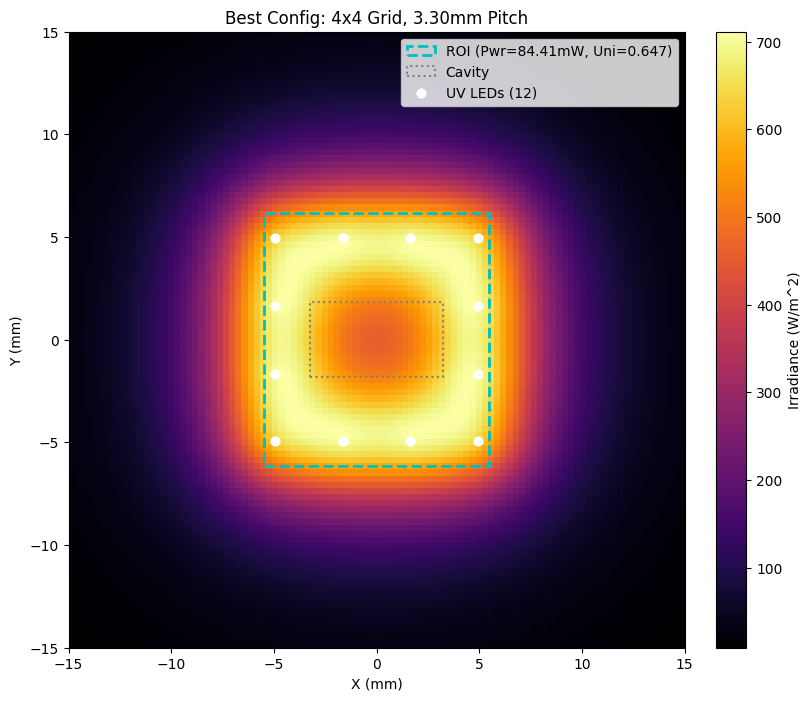

In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import interp1d
import pandas as pd
from datetime import datetime
import itertools # 파라미터 조합 생성을 위해 추가

# ======================================================================================
# 1. 시뮬레이션 파라미터 및 최적화 설정
# ======================================================================================
# --- 광학계 기본 설정 ---
PHASEMASK_TO_OBJECT_DISTANCE_MM = 6.0
ROI_WIDTH_MM = 11.0
ROI_HEIGHT_MM = 12.3

# --- 시나리오 A 기구적 수치 ---
LED_THICKNESS_MM = 2.3
OTHER_PARTS_THICKNESS_MM = 0.1
CAVITY_WIDTH_MM = 6.45
CAVITY_HEIGHT_MM = 3.63

# --- LED 특성 ---
LED_ANGLES_DEG_ORIGINAL = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
LED_INTENSITIES_ORIGINAL = np.array([1.0, 0.99, 0.98, 0.95, 0.90, 0.82, 0.70, 0.50, 0.25, 0.0])
# Passivation 효과 근사 (빔 퍼짐)
PASSIVATION_SPREAD_FACTOR = 1.07 # 빔 퍼짐 정도 조절 (1.0이면 효과 없음)
LED_ANGLES_DEG = np.clip(LED_ANGLES_DEG_ORIGINAL * PASSIVATION_SPREAD_FACTOR, 0, 95); LED_ANGLES_DEG[0]=0
LED_INTENSITIES = LED_INTENSITIES_ORIGINAL
# 보정된 단일 LED 파워 (Calibration 모드 실행 후 얻은 값으로 업데이트)
SINGLE_LED_TOTAL_POWER_MW = 15.832 # 예시 값

# --- White LED 설정 ---
NUM_WHITE_LEDS = 2
CROSSTALK_MIN_DISTANCE_MM = 5.0

# --- 시뮬레이션 정밀도 ---
RESOLUTION = 100 # 빠른 탐색을 위해 해상도 낮춤 (최종 확인 시 200 이상으로)
GRID_SIZE_MM = 30

# --- 최적화 파라미터 탐색 범위 ---
GRID_DIM_RANGE = range(4, 10) # 예: 4x4, 5x5, 6x6 그리드 탐색
GRID_PITCH_RANGE_MM = np.arange(2.5, 4.1, 0.2) # 예: 2.5mm부터 4.0mm까지 0.2mm 간격 탐색 (최소 2.5mm 유지)

# --- Loss Function 가중치 ---
W_COUNT = 1e+12      # LED 개수 가중치
W_POWER = 100.0    # 파워 부족 페널티 가중치 (매우 높게)
W_UNIFORMITY = 100.0 # 불균일성 페널티 가중치
W_CROSSTALK = 10000.0 # Crosstalk 발생 페널티 가중치 (매우 높게)
TARGET_POWER_MW = 34.0

# ======================================================================================
# 2. 핵심 함수 (White LED 배치 및 Crosstalk 검사 추가)
# ======================================================================================
def get_beam_profile_func(angles, intensities):
    f = interp1d(angles, intensities, kind='linear', fill_value=0.0, bounds_error=False)
    return f

def create_led_layout(grid_dim_x, grid_dim_y, pitch, cavity_w, cavity_h):
    # (이전 코드와 동일)
    led_positions = []; potential_slots = []
    offset_x = (grid_dim_x - 1) * pitch / 2.0; offset_y = (grid_dim_y - 1) * pitch / 2.0
    for i in range(grid_dim_x):
        for j in range(grid_dim_y):
            x = i * pitch - offset_x; y = j * pitch - offset_y
            slot_pos = np.array([x, y, 0])
            potential_slots.append(slot_pos) # 모든 그리드 위치 저장
            if abs(x) < cavity_w / 2.0 and abs(y) < cavity_h / 2.0: continue
            led_positions.append(slot_pos) # UV LED 위치만 저장
    return led_positions, potential_slots # UV LED 위치와 모든 그리드 슬롯 위치 반환

# ✨ NEW! ✨ White LED 배치 및 Crosstalk 검사 함수
def place_white_leds_and_check_crosstalk(uv_led_positions, potential_slots, cavity_w, cavity_h, num_white, min_dist):
    """
    UV LED 배치 후, Crosstalk 제약을 만족하는 White LED 위치를 찾습니다.

    [Inputs]
    - uv_led_positions (list): 배치된 UV LED 좌표 리스트.
    - potential_slots (list): White LED를 배치할 수 있는 모든 그리드 슬롯 좌표 리스트.
    - cavity_w, cavity_h (float): 중앙 구멍 크기 (White LED도 구멍 안에 배치될 수 없음).
    - num_white (int): 배치할 White LED 개수.
    - min_dist (float): UV-White LED 간 최소 허용 거리 (mm).

    [Output]
    - white_led_positions (list): 성공적으로 배치된 White LED 좌표 리스트 (실패 시 빈 리스트).
    - crosstalk_penalty (float): Crosstalk 발생 시 페널티 값 (W_CROSSTALK), 미발생 시 0.
    """
    white_led_positions = []
    available_slots = []

    # 1. 구멍 밖 & UV LED가 없는 빈 슬롯 찾기
    uv_pos_set = {tuple(pos) for pos in uv_led_positions}
    for slot in potential_slots:
        if tuple(slot) not in uv_pos_set and \
           not (abs(slot[0]) < cavity_w / 2.0 and abs(slot[1]) < cavity_h / 2.0):
            available_slots.append(slot)

    # 2. 모든 빈 슬롯 조합 중 최적의 White LED 위치 찾기 (가장 멀리 떨어진 조합)
    best_white_combo = []
    max_min_distance_sum = -1 # UV와의 최소 거리 합 최대화

    if len(available_slots) >= num_white:
        for combo in itertools.combinations(available_slots, num_white):
            current_min_distance_sum = 0
            valid_combo = True
            for white_pos in combo:
                min_dist_to_uv = np.inf
                for uv_pos in uv_led_positions:
                    dist = np.linalg.norm(white_pos - uv_pos)
                    if dist < min_dist: # Crosstalk 제약 위반
                        valid_combo = False
                        break
                    min_dist_to_uv = min(min_dist_to_uv, dist)
                if not valid_combo: break
                current_min_distance_sum += min_dist_to_uv # 이 White LED와 가장 가까운 UV와의 거리

            if valid_combo and current_min_distance_sum > max_min_distance_sum:
                 max_min_distance_sum = current_min_distance_sum
                 best_white_combo = list(combo)

    white_led_positions = best_white_combo
    crosstalk_penalty = 0.0 if len(white_led_positions) == num_white else W_CROSSTALK # 배치 성공 여부로 페널티 결정

    return white_led_positions, crosstalk_penalty

# ... simulate_illumination, analyze_roi 함수는 이전 코드와 동일 ...
def simulate_illumination(led_positions, beam_profile_func, target_z, grid_size, resolution):
    x_coords=np.linspace(-grid_size / 2, grid_size / 2, resolution); y_coords=np.linspace(-grid_size / 2, grid_size / 2, resolution)
    X, Y=np.meshgrid(x_coords, y_coords); total_illum_map=np.zeros_like(X)
    for led_pos in led_positions:
        vectors_to_led=led_pos - np.stack([X, Y, np.full_like(X, target_z)], axis=-1)
        distances=np.linalg.norm(vectors_to_led, axis=-1); distances=np.where(distances==0, 1e-9, distances)
        cos_theta=(target_z - led_pos[2]) / distances
        angle_degrees=np.degrees(np.arccos(np.clip(cos_theta, 0, 1)))
        beam_intensity=beam_profile_func(angle_degrees)
        intensity_contribution=(beam_intensity * cos_theta) / (distances**2)
        total_illum_map += intensity_contribution
    return X, Y, total_illum_map

def analyze_roi(X, Y, illum_map, roi_w, roi_h, effective_single_led_power_mw, num_leds):
    roi_mask=(np.abs(X) <= roi_w / 2) & (np.abs(Y) <= roi_h / 2)
    roi_illum=np.where(roi_mask, illum_map, np.nan)
    if np.all(np.isnan(roi_illum)): return 0, 0, 0.0
    dx=X[0, 1] - X[0, 0]; dy=Y[1, 0] - Y[0, 0]; pixel_area_mm2=dx * dy
    sim_total_integral=np.sum(illum_map[~np.isnan(illum_map)]) * pixel_area_mm2
    total_led_power_mw_reference=effective_single_led_power_mw * num_leds
    scale_factor=(total_led_power_mw_reference / sim_total_integral) if sim_total_integral > 0 else 0.0
    roi_power_mw=np.nansum(roi_illum) * pixel_area_mm2 * scale_factor
    uniformity=np.nanmin(roi_illum) / np.nanmax(roi_illum) if np.nanmax(roi_illum) > 0 else 0
    return roi_power_mw, uniformity, scale_factor

# ✨ NEW! ✨ Loss Function 계산 함수
def calculate_loss(num_uv, power_roi, uniformity_roi, crosstalk_penalty):
    """정의된 가중치를 사용하여 Loss 값을 계산합니다."""
    
    # 파워 페널티 (목표 미달 시)
    power_penalty = max(0, TARGET_POWER_MW - power_roi)
    
    # 균일도 페널티 (1에서 벗어날수록 증가)
    uniformity_penalty = (1.0 - uniformity_roi)
    
    # 최종 Loss 계산
    loss = (W_COUNT * num_uv +
            W_POWER * power_penalty +
            W_UNIFORMITY * uniformity_penalty +
            crosstalk_penalty) # crosstalk_penalty는 W_CROSSTALK가 이미 곱해져 있음
            
    return loss, power_penalty, uniformity_penalty

# ======================================================================================
# 3. 로그 기록 함수 (이전과 동일)
# ======================================================================================
def log_simulation_result(log_file, data):
    # ... (이전 코드와 동일) ...
    try: df = pd.read_csv(log_file)
    except FileNotFoundError: df = pd.DataFrame(columns=data.keys())
    new_log = pd.DataFrame([data]); df = pd.concat([df, new_log], ignore_index=True)
    df.to_csv(log_file, index=False); print(f"\n✅ Optimization results logged to '{log_file}'")

# ======================================================================================
# 4. 최적화 실행 및 결과 처리
# ======================================================================================
if __name__ == "__main__":
    
    actual_led_object_distance = PHASEMASK_TO_OBJECT_DISTANCE_MM - OTHER_PARTS_THICKNESS_MM - LED_THICKNESS_MM
    beam_func = get_beam_profile_func(LED_ANGLES_DEG, LED_INTENSITIES)
    
    # 보정된 SINGLE_LED_TOTAL_POWER_MW 값 사용 확인
    if SINGLE_LED_TOTAL_POWER_MW == INITIAL_SINGLE_LED_POWER_MW:
        print("\nWARNING: SINGLE_LED_TOTAL_POWER_MW might need calibration.")
        print("         Using the initial value for optimization.")
        
    results_list = [] # 모든 시뮬레이션 결과를 저장할 리스트
    
    # 파라미터 조합 생성 (Grid Dim은 X, Y 동일하게 가정)
    param_combinations = list(itertools.product(GRID_DIM_RANGE, GRID_PITCH_RANGE_MM))
    total_combinations = len(param_combinations)
    print(f"--- Starting Optimization Search ({total_combinations} combinations) ---")
    print(f"    Grid Dims: {list(GRID_DIM_RANGE)}")
    print(f"    Grid Pitches (mm): {GRID_PITCH_RANGE_MM}")
    print(f"    Min Pitch Constraint: >= 2.5 mm")
    print("-" * 60)
    
    start_time_total = datetime.now()
    
    # 모든 파라미터 조합에 대해 시뮬레이션 실행
    for idx, (grid_dim, pitch) in enumerate(param_combinations):
        
        # 물리적 제약 조건 확인 (LED 최소 간격)
        if pitch < 2.5: # 실제 LED 크기 고려
             print(f"Skipping: Pitch {pitch:.2f}mm < 2.5mm (Physical constraint)")
             continue
             
        grid_dim_x = grid_dim_y = grid_dim # 정사각형 그리드 가정
        
        # 1. UV LED 배치 생성
        uv_led_positions, potential_slots = create_led_layout(grid_dim_x, grid_dim_y, pitch, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM)
        num_uv_leds = len(uv_led_positions)
        
        # 2. White LED 배치 및 Crosstalk 검사
        white_led_positions, crosstalk_penalty_value = place_white_leds_and_check_crosstalk(
            uv_led_positions, potential_slots, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, NUM_WHITE_LEDS, CROSSTALK_MIN_DISTANCE_MM
        )
        crosstalk_occurred = (crosstalk_penalty_value > 0)
        
        # 3. 시뮬레이션 실행 (UV LED만으로)
        X_mm, Y_mm, illum_map_arb = simulate_illumination(
            uv_led_positions, beam_func, actual_led_object_distance, GRID_SIZE_MM, RESOLUTION
        )
        
        # 4. ROI 분석
        power_on_roi, uniformity_roi, _ = analyze_roi(
            X_mm, Y_mm, illum_map_arb, ROI_WIDTH_MM, ROI_HEIGHT_MM, SINGLE_LED_TOTAL_POWER_MW, num_uv_leds
        )
        
        # 5. Loss Function 계산
        total_loss, power_pen, unif_pen = calculate_loss(
            num_uv_leds, power_on_roi, uniformity_roi, crosstalk_penalty_value
        )
        
        # 결과 저장
        results_list.append({
            'Grid_Dim': grid_dim,
            'Pitch_mm': round(pitch, 2),
            'Num_UV_LEDs': num_uv_leds,
            'Power_ROI_mW': round(power_on_roi, 2),
            'Uniformity_ROI': round(uniformity_roi, 3),
            'White_LED_Placeable': not crosstalk_occurred,
            'Total_Loss': round(total_loss, 2),
            'Power_Penalty': round(power_pen, 2),
            'Uniformity_Penalty': round(unif_pen, 3),
            'Crosstalk_Penalty': int(crosstalk_penalty_value)
        })
        
        print(f"({idx+1}/{total_combinations}) Grid={grid_dim}x{grid_dim}, Pitch={pitch:.2f}mm -> UV={num_uv_leds}, Pwr={power_on_roi:.2f}, Uni={uniformity_roi:.3f}, Wht OK?={'Yes' if not crosstalk_occurred else 'No!'}, Loss={total_loss:.2f}")

    end_time_total = datetime.now()
    print("-" * 60)
    print(f"Optimization Search Finished. Total time: {end_time_total - start_time_total}")

    # --- 결과 처리 및 로깅 (수정됨) ---
    if not results_list:
        print("\nNo valid configurations found in the specified range.")
    else:
        results_df = pd.DataFrame(results_list)
        results_df_sorted = results_df.sort_values(by='Total_Loss').reset_index(drop=True)
        
        # ✨ NEW! ✨ DataFrame 전체를 CSV 파일로 직접 저장합니다.
        log_file = 'optimization_results.csv'
        results_df_sorted.to_csv(log_file, index=False)
        print(f"\n✅ Optimization results logged to '{log_file}'")
        # --- 수정 끝 ---
        
        # 상위 5개 결과 출력
        print("\n--- Top 5 Optimal Configurations (Lower Loss is better) ---")
        print(results_df_sorted.head(5).to_string())

        # --- 최적 후보 시각화 ---
        best_config = results_df_sorted.iloc[0]
        print(f"\n--- Visualizing Best Configuration (Loss={best_config['Total_Loss']:.2f}) ---")
        best_grid_dim = int(best_config['Grid_Dim'])
        best_pitch = best_config['Pitch_mm']
        
        best_uv_leds, best_slots = create_led_layout(best_grid_dim, best_grid_dim, best_pitch, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM)
        best_white_leds, _ = place_white_leds_and_check_crosstalk(best_uv_leds, best_slots, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, NUM_WHITE_LEDS, CROSSTALK_MIN_DISTANCE_MM)
        
        X_best, Y_best, illum_best = simulate_illumination(best_uv_leds, beam_func, actual_led_object_distance, GRID_SIZE_MM, RESOLUTION)
        power_best, uniformity_best, scale_factor_best = analyze_roi(X_best, Y_best, illum_best, ROI_WIDTH_MM, ROI_HEIGHT_MM, SINGLE_LED_TOTAL_POWER_MW, len(best_uv_leds))
        irradiance_map_best_W_m2 = illum_best * scale_factor_best * (MM_PER_M**2 / 1000.0)

        fig_best, ax_best = plt.subplots(figsize=(10, 8))
        im_best = ax_best.imshow(irradiance_map_best_W_m2, extent=[-GRID_SIZE_MM/2, GRID_SIZE_MM/2, -GRID_SIZE_MM/2, GRID_SIZE_MM/2], cmap='inferno', origin='lower')
        roi_rect_best = patches.Rectangle((-ROI_WIDTH_MM/2, -ROI_HEIGHT_MM/2), ROI_WIDTH_MM, ROI_HEIGHT_MM, lw=2, ec='c', fc='none', ls='--', label=f'ROI (Pwr={power_best:.2f}mW, Uni={uniformity_best:.3f})')
        cavity_rect_best = patches.Rectangle((-CAVITY_WIDTH_MM/2, -CAVITY_HEIGHT_MM/2), CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, lw=1.5, ec='gray', fc='none', ls=':', label='Cavity')
        ax_best.add_patch(roi_rect_best); ax_best.add_patch(cavity_rect_best)
        if best_uv_leds: uv_x = [p[0] for p in best_uv_leds]; uv_y = [p[1] for p in best_uv_leds]; ax_best.scatter(uv_x, uv_y, c='w', marker='o', s=40, label=f'UV LEDs ({len(best_uv_leds)})')
        if best_white_leds: wh_x = [p[0] for p in best_white_leds]; wh_y = [p[1] for p in best_white_leds]; ax_best.scatter(wh_x, wh_y, c='lime', marker='s', s=40, label=f'White LEDs ({len(best_white_leds)})')
        ax_best.set_title(f'Best Config: {best_grid_dim}x{best_grid_dim} Grid, {best_pitch:.2f}mm Pitch'); ax_best.set_xlabel('X (mm)'); ax_best.set_ylabel('Y (mm)'); ax_best.legend()
        cbar_best = fig_best.colorbar(im_best, ax=ax_best, fraction=0.046, pad=0.04); cbar_best.set_label('Irradiance (W/m^2)'); plt.show()


## limit # of uv LED

--- Starting Optimization Search (64 combinations) ---
    Grid Dims: [4, 5, 6, 7, 8, 9, 10, 11]
    Grid Pitches (mm): [2.5 2.7 2.9 3.1 3.3 3.5 3.7 3.9]
    Min Pitch Constraint: >= 2.5 mm
------------------------------------------------------------
(1/64) Grid=4x4, Pitch=2.50mm -> UV=12, Pwr=108.42, Uni=0.355, Wht OK?=No!, Loss=10018.45
(2/64) Grid=4x4, Pitch=2.70mm -> UV=12, Pwr=102.97, Uni=0.432, Wht OK?=No!, Loss=10017.68
(3/64) Grid=4x4, Pitch=2.90mm -> UV=12, Pwr=97.10, Uni=0.520, Wht OK?=No!, Loss=10016.80
(4/64) Grid=4x4, Pitch=3.10mm -> UV=12, Pwr=90.88, Uni=0.618, Wht OK?=No!, Loss=10015.82
(5/64) Grid=4x4, Pitch=3.30mm -> UV=12, Pwr=84.41, Uni=0.647, Wht OK?=No!, Loss=10015.53
(6/64) Grid=4x4, Pitch=3.50mm -> UV=12, Pwr=77.80, Uni=0.597, Wht OK?=No!, Loss=10016.03
(7/64) Grid=4x4, Pitch=3.70mm -> UV=16, Pwr=114.50, Uni=0.643, Wht OK?=No!, Loss=10019.57
(8/64) Grid=4x4, Pitch=3.90mm -> UV=16, Pwr=107.71, Uni=0.699, Wht OK?=No!, Loss=10019.01
(9/64) Grid=5x5, Pitch=2.50mm -> 

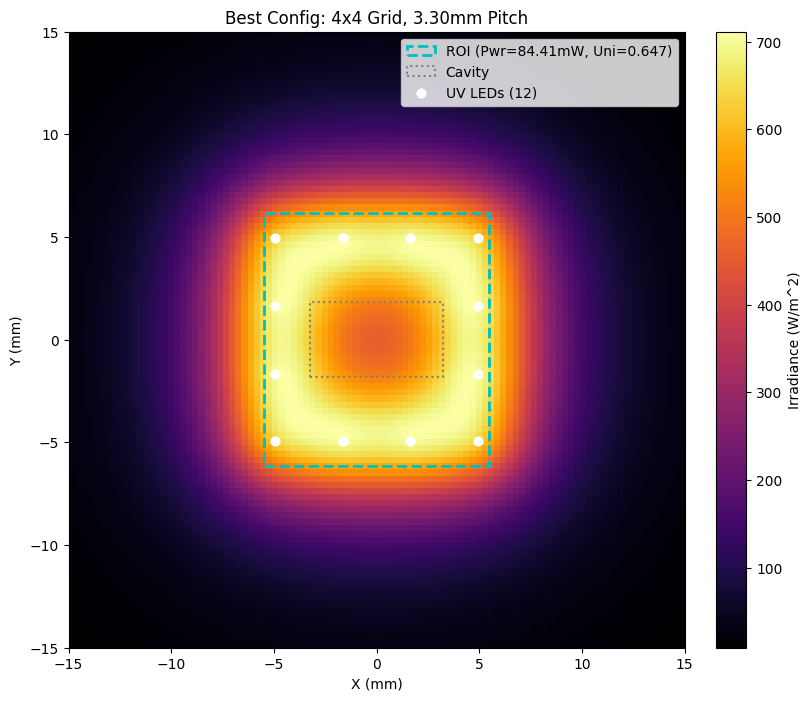

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import interp1d
import pandas as pd
from datetime import datetime
import itertools # 파라미터 조합 생성을 위해 추가

# ======================================================================================
# 1. 시뮬레이션 파라미터 및 최적화 설정
# ======================================================================================
# --- 광학계 기본 설정 ---
PHASEMASK_TO_OBJECT_DISTANCE_MM = 6.0
ROI_WIDTH_MM = 11.0
ROI_HEIGHT_MM = 12.3

# --- 시나리오 A 기구적 수치 ---
LED_THICKNESS_MM = 2.3
OTHER_PARTS_THICKNESS_MM = 0.1
CAVITY_WIDTH_MM = 6.45
CAVITY_HEIGHT_MM = 3.63

# --- LED 특성 ---
LED_ANGLES_DEG_ORIGINAL = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
LED_INTENSITIES_ORIGINAL = np.array([1.0, 0.99, 0.98, 0.95, 0.90, 0.82, 0.70, 0.50, 0.25, 0.0])
# Passivation 효과 근사 (빔 퍼짐)
PASSIVATION_SPREAD_FACTOR = 1.07
LED_ANGLES_DEG = np.clip(LED_ANGLES_DEG_ORIGINAL * PASSIVATION_SPREAD_FACTOR, 0, 95); LED_ANGLES_DEG[0]=0
LED_INTENSITIES = LED_INTENSITIES_ORIGINAL
# 보정된 단일 LED 파워 (Calibration 모드 실행 후 얻은 값으로 업데이트)
SINGLE_LED_TOTAL_POWER_MW = 15.832 # 사용자 입력값 반영

# --- White LED 설정 ---
NUM_WHITE_LEDS = 2
CROSSTALK_MIN_DISTANCE_MM = 5.0

# --- 시뮬레이션 정밀도 ---
RESOLUTION = 100
GRID_SIZE_MM = 30
MM_PER_M = 1000.0

# --- 최적화 파라미터 탐색 범위 ---
GRID_DIM_RANGE = range(4, 12) # 범위 좁혀서 테스트 시간 단축 (원래: 4, 10)
GRID_PITCH_RANGE_MM = np.arange(2.5, 4.1, 0.2)

# --- Loss Function 가중치 ---
W_COUNT = 1.0 # 이전 답변 내용 반영하여 수정 (원래: 1e+12)
W_POWER = 10.0 # 파워 부족 페널티 가중치 (매우 높게)
W_UNIFORMITY = 10.0 # 불균일성 페널티 가중치
W_CROSSTALK = 10000.0 # Crosstalk 발생 페널티 가중치 (매우 높게)
TARGET_POWER_MW = 34.0

# ======================================================================================
# 2. 핵심 함수 (White LED 배치 및 Crosstalk 검사 추가)
# ======================================================================================
def get_beam_profile_func(angles, intensities):
    f = interp1d(angles, intensities, kind='linear', fill_value=0.0, bounds_error=False)
    return f

def create_led_layout(grid_dim_x, grid_dim_y, pitch, cavity_w, cavity_h):
    led_positions = []; potential_slots = []
    offset_x = (grid_dim_x - 1) * pitch / 2.0; offset_y = (grid_dim_y - 1) * pitch / 2.0
    for i in range(grid_dim_x):
        for j in range(grid_dim_y):
            x = i * pitch - offset_x; y = j * pitch - offset_y
            slot_pos = np.array([x, y, 0])
            potential_slots.append(slot_pos)
            if abs(x) < cavity_w / 2.0 and abs(y) < cavity_h / 2.0: continue
            led_positions.append(slot_pos)
    return led_positions, potential_slots

def place_white_leds_and_check_crosstalk(uv_led_positions, potential_slots, cavity_w, cavity_h, num_white, min_dist):
    white_led_positions = []; available_slots = []
    uv_pos_set = {tuple(pos) for pos in uv_led_positions}
    for slot in potential_slots:
        if tuple(slot) not in uv_pos_set and \
           not (abs(slot[0]) < cavity_w / 2.0 and abs(slot[1]) < cavity_h / 2.0):
            available_slots.append(slot)

    best_white_combo = []; max_min_distance_sum = -1
    if len(available_slots) >= num_white:
        for combo in itertools.combinations(available_slots, num_white):
            current_min_distance_sum = 0; valid_combo = True
            for white_pos in combo:
                min_dist_to_uv = np.inf
                for uv_pos in uv_led_positions:
                    dist = np.linalg.norm(white_pos - uv_pos)
                    if dist < min_dist: valid_combo = False; break
                    min_dist_to_uv = min(min_dist_to_uv, dist)
                if not valid_combo: break
                current_min_distance_sum += min_dist_to_uv
            if valid_combo and current_min_distance_sum > max_min_distance_sum:
                 max_min_distance_sum = current_min_distance_sum; best_white_combo = list(combo)

    white_led_positions = best_white_combo
    crosstalk_penalty = 0.0 if len(white_led_positions) == num_white else W_CROSSTALK
    return white_led_positions, crosstalk_penalty

def simulate_illumination(led_positions, beam_profile_func, target_z, grid_size, resolution):
    x_coords=np.linspace(-grid_size / 2, grid_size / 2, resolution); y_coords=np.linspace(-grid_size / 2, grid_size / 2, resolution)
    X, Y=np.meshgrid(x_coords, y_coords); total_illum_map=np.zeros_like(X)
    for led_pos in led_positions:
        vectors_to_led=led_pos - np.stack([X, Y, np.full_like(X, target_z)], axis=-1)
        distances=np.linalg.norm(vectors_to_led, axis=-1); distances=np.where(distances==0, 1e-9, distances)
        cos_theta=(target_z - led_pos[2]) / distances
        angle_degrees=np.degrees(np.arccos(np.clip(cos_theta, 0, 1)))
        beam_intensity=beam_profile_func(angle_degrees)
        intensity_contribution=(beam_intensity * cos_theta) / (distances**2)
        total_illum_map += intensity_contribution
    return X, Y, total_illum_map

def analyze_roi(X, Y, illum_map, roi_w, roi_h, effective_single_led_power_mw, num_leds):
    roi_mask=(np.abs(X) <= roi_w / 2) & (np.abs(Y) <= roi_h / 2)
    roi_illum=np.where(roi_mask, illum_map, np.nan)
    if np.all(np.isnan(roi_illum)): return 0, 0, 0.0
    dx=X[0, 1] - X[0, 0]; dy=Y[1, 0] - Y[0, 0]; pixel_area_mm2=dx * dy
    sim_total_integral=np.sum(illum_map[~np.isnan(illum_map)]) * pixel_area_mm2
    total_led_power_mw_reference=effective_single_led_power_mw * num_leds
    scale_factor=(total_led_power_mw_reference / sim_total_integral) if sim_total_integral > 0 else 0.0
    roi_power_mw=np.nansum(roi_illum) * pixel_area_mm2 * scale_factor
    uniformity=np.nanmin(roi_illum) / np.nanmax(roi_illum) if np.nanmax(roi_illum) > 0 else 0
    return roi_power_mw, uniformity, scale_factor

def calculate_loss(num_uv, power_roi, uniformity_roi, crosstalk_penalty):
    power_penalty = max(0, TARGET_POWER_MW - power_roi)
    uniformity_penalty = (1.0 - uniformity_roi)
    loss = (W_COUNT * num_uv +
            W_POWER * power_penalty +
            W_UNIFORMITY * uniformity_penalty +
            crosstalk_penalty)
    return loss, power_penalty, uniformity_penalty

# ======================================================================================
# 3. 로그 기록 함수 (이제 사용되지 않음, 삭제 가능)
# ======================================================================================
# def log_simulation_result(log_file, data):
#     ...

# ======================================================================================
# 4. 최적화 실행 및 결과 처리
# ======================================================================================
if __name__ == "__main__":
    
    actual_led_object_distance = PHASEMASK_TO_OBJECT_DISTANCE_MM - OTHER_PARTS_THICKNESS_MM - LED_THICKNESS_MM
    beam_func = get_beam_profile_func(LED_ANGLES_DEG, LED_INTENSITIES)
    
    if SINGLE_LED_TOTAL_POWER_MW == INITIAL_SINGLE_LED_POWER_MW:
        print("\nWARNING: SINGLE_LED_TOTAL_POWER_MW might need calibration.")
        print("         Using the initial value for optimization.")
        
    results_list = []
    param_combinations = list(itertools.product(GRID_DIM_RANGE, GRID_PITCH_RANGE_MM))
    total_combinations = len(param_combinations)
    print(f"--- Starting Optimization Search ({total_combinations} combinations) ---")
    print(f"    Grid Dims: {list(GRID_DIM_RANGE)}")
    print(f"    Grid Pitches (mm): {GRID_PITCH_RANGE_MM}")
    print(f"    Min Pitch Constraint: >= 2.5 mm")
    print("-" * 60)
    start_time_total = datetime.now()
    
    for idx, (grid_dim, pitch) in enumerate(param_combinations):
        if pitch < 2.5:
             print(f"Skipping: Pitch {pitch:.2f}mm < 2.5mm")
             continue
        grid_dim_x = grid_dim_y = grid_dim
        uv_led_positions, potential_slots = create_led_layout(grid_dim_x, grid_dim_y, pitch, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM)
        num_uv_leds = len(uv_led_positions)
        white_led_positions, crosstalk_penalty_value = place_white_leds_and_check_crosstalk(uv_led_positions, potential_slots, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, NUM_WHITE_LEDS, CROSSTALK_MIN_DISTANCE_MM)
        crosstalk_occurred = (crosstalk_penalty_value > 0)
        X_mm, Y_mm, illum_map_arb = simulate_illumination(uv_led_positions, beam_func, actual_led_object_distance, GRID_SIZE_MM, RESOLUTION)
        power_on_roi, uniformity_roi, _ = analyze_roi(X_mm, Y_mm, illum_map_arb, ROI_WIDTH_MM, ROI_HEIGHT_MM, SINGLE_LED_TOTAL_POWER_MW, num_uv_leds)
        total_loss, power_pen, unif_pen = calculate_loss(num_uv_leds, power_on_roi, uniformity_roi, crosstalk_penalty_value)
        results_list.append({'Grid_Dim': grid_dim, 'Pitch_mm': round(pitch, 2), 'Num_UV_LEDs': num_uv_leds, 'Power_ROI_mW': round(power_on_roi, 2), 'Uniformity_ROI': round(uniformity_roi, 3), 'White_LED_Placeable': not crosstalk_occurred, 'Total_Loss': round(total_loss, 2), 'Power_Penalty': round(power_pen, 2), 'Uniformity_Penalty': round(unif_pen, 3), 'Crosstalk_Penalty': int(crosstalk_penalty_value)})
        print(f"({idx+1}/{total_combinations}) Grid={grid_dim}x{grid_dim}, Pitch={pitch:.2f}mm -> UV={num_uv_leds}, Pwr={power_on_roi:.2f}, Uni={uniformity_roi:.3f}, Wht OK?={'Yes' if not crosstalk_occurred else 'No!'}, Loss={total_loss:.2f}")

    end_time_total = datetime.now()
    print("-" * 60)
    print(f"Optimization Search Finished. Total time: {end_time_total - start_time_total}")

    # --- 결과 처리 및 로깅 (수정됨) ---
    if not results_list:
        print("\nNo valid configurations found in the specified range.")
    else:
        results_df = pd.DataFrame(results_list)
        results_df_sorted = results_df.sort_values(by='Total_Loss').reset_index(drop=True)
        
        # <<< --- 여기가 수정된 부분 --- >>>
        # DataFrame 전체를 CSV 파일로 직접 저장
        log_file = 'optimization_results.csv'
        results_df_sorted.to_csv(log_file, index=False)
        print(f"\n✅ Optimization results logged to '{log_file}'")
        # <<< --- 수정 끝 --- >>>
        
        # 상위 5개 결과 출력
        print("\n--- Top 5 Optimal Configurations (Lower Loss is better) ---")
        print(results_df_sorted.head(5).to_string())

        # --- 최적 후보 시각화 ---
        if not results_df_sorted.empty: # 결과가 있을 때만 시각화 시도
            best_config = results_df_sorted.iloc[0]
            print(f"\n--- Visualizing Best Configuration (Loss={best_config['Total_Loss']:.2f}) ---")
            best_grid_dim = int(best_config['Grid_Dim']); best_pitch = best_config['Pitch_mm']
            best_uv_leds, best_slots = create_led_layout(best_grid_dim, best_grid_dim, best_pitch, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM)
            best_white_leds, _ = place_white_leds_and_check_crosstalk(best_uv_leds, best_slots, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, NUM_WHITE_LEDS, CROSSTALK_MIN_DISTANCE_MM)
            X_best, Y_best, illum_best = simulate_illumination(best_uv_leds, beam_func, actual_led_object_distance, GRID_SIZE_MM, RESOLUTION)
            power_best, uniformity_best, scale_factor_best = analyze_roi(X_best, Y_best, illum_best, ROI_WIDTH_MM, ROI_HEIGHT_MM, SINGLE_LED_TOTAL_POWER_MW, len(best_uv_leds))
            irradiance_map_best_W_m2 = illum_best * scale_factor_best * (MM_PER_M**2 / 1000.0)

            fig_best, ax_best = plt.subplots(figsize=(10, 8)); im_best = ax_best.imshow(irradiance_map_best_W_m2, extent=[-GRID_SIZE_MM/2, GRID_SIZE_MM/2, -GRID_SIZE_MM/2, GRID_SIZE_MM/2], cmap='inferno', origin='lower'); roi_rect_best = patches.Rectangle((-ROI_WIDTH_MM/2, -ROI_HEIGHT_MM/2), ROI_WIDTH_MM, ROI_HEIGHT_MM, lw=2, ec='c', fc='none', ls='--', label=f'ROI (Pwr={power_best:.2f}mW, Uni={uniformity_best:.3f})'); cavity_rect_best = patches.Rectangle((-CAVITY_WIDTH_MM/2, -CAVITY_HEIGHT_MM/2), CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, lw=1.5, ec='gray', fc='none', ls=':', label='Cavity'); ax_best.add_patch(roi_rect_best); ax_best.add_patch(cavity_rect_best)
            if best_uv_leds: uv_x = [p[0] for p in best_uv_leds]; uv_y = [p[1] for p in best_uv_leds]; ax_best.scatter(uv_x, uv_y, c='w', marker='o', s=40, label=f'UV LEDs ({len(best_uv_leds)})')
            if best_white_leds: wh_x = [p[0] for p in best_white_leds]; wh_y = [p[1] for p in best_white_leds]; ax_best.scatter(wh_x, wh_y, c='lime', marker='s', s=40, label=f'White LEDs ({len(best_white_leds)})')
            ax_best.set_title(f'Best Config: {best_grid_dim}x{best_grid_dim} Grid, {best_pitch:.2f}mm Pitch'); ax_best.set_xlabel('X (mm)'); ax_best.set_ylabel('Y (mm)'); ax_best.legend(); cbar_best = fig_best.colorbar(im_best, ax=ax_best, fraction=0.046, pad=0.04); cbar_best.set_label('Irradiance (W/m^2)'); plt.show()
        else:
             print("\nNo configurations to visualize.")

--- Starting Optimization Search (140 combinations) ---
    UV LED Counts: [4, 6]
    White LED Counts: [1, 2]
    Array Radii (mm): [ 4.   4.2  4.4  4.6  4.8  5.   5.2  5.4  5.6  5.8  6.   6.2  6.4  6.6
  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2  8.4  8.6  8.8  9.   9.2  9.4
  9.6  9.8 10.  10.2 10.4 10.6 10.8]
    Min LED Separation Constraint: >= 2.50 mm
    White LED Crosstalk Constraint: >= 5.00 mm
------------------------------------------------------------
(1/140) UV=4, Rad=4.00mm -> Skipped (Placement Constraint)
(2/140) UV=4, Rad=4.20mm -> Skipped (Placement Constraint)
(3/140) UV=4, Rad=4.40mm -> Skipped (Placement Constraint)
(4/140) UV=4, Rad=4.60mm -> Skipped (Placement Constraint)
(5/140) UV=4, Rad=4.80mm -> Skipped (Placement Constraint)
(6/140) UV=4, Rad=5.00mm -> Skipped (Placement Constraint)
(7/140) UV=4, Rad=5.20mm -> Skipped (Placement Constraint)
(8/140) UV=4, Rad=5.40mm -> Skipped (Placement Constraint)
(9/140) UV=4, Wht=1, Rad=5.60mm -> Pwr=0.00, Uni=0.000, Wht OK

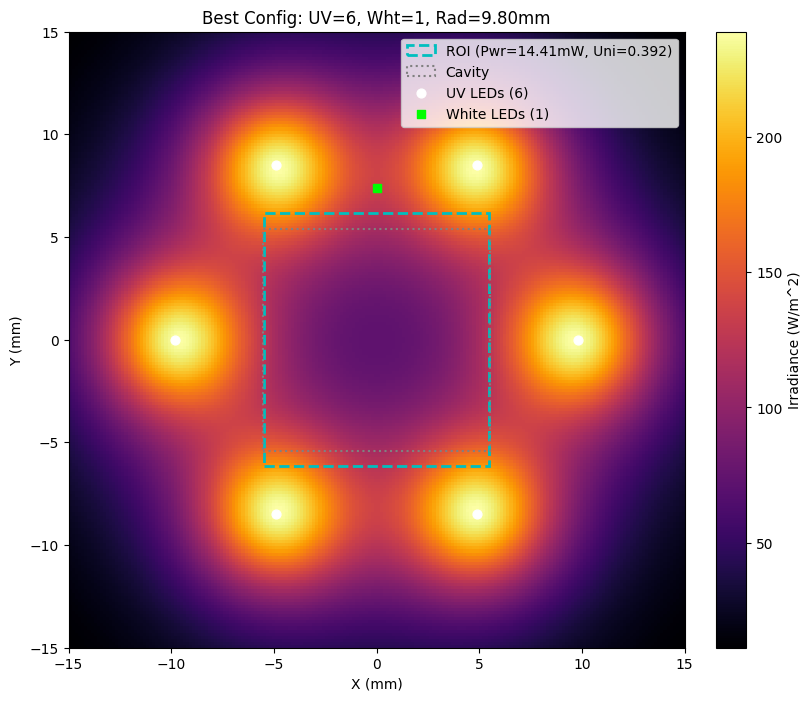

In [33]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import interp1d
import pandas as pd
from datetime import datetime
import itertools

# ======================================================================================
# 1. 시뮬레이션 파라미터 및 최적화 설정
# ======================================================================================
# --- 광학계 기본 설정 ---
PHASEMASK_TO_OBJECT_DISTANCE_MM = 6.0
ROI_WIDTH_MM = 11.0
ROI_HEIGHT_MM = 12.3

# # --- 시나리오 A 기구적 수치 ---
# LED_THICKNESS_MM = 2.3
# OTHER_PARTS_THICKNESS_MM = 0.1
# CAVITY_WIDTH_MM = 6.45
# CAVITY_HEIGHT_MM = 3.63

# --- 시나리오 B 기구적 수치 ---
LED_THICKNESS_MM = 2.3
OTHER_PARTS_THICKNESS_MM = 0.1
CAVITY_WIDTH_MM = 11.06
CAVITY_HEIGHT_MM = 10.81

# --- LED 특성 ---
LED_ANGLES_DEG_ORIGINAL = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
LED_INTENSITIES_ORIGINAL = np.array([1.0, 0.99, 0.98, 0.95, 0.90, 0.82, 0.70, 0.50, 0.25, 0.0])
PASSIVATION_SPREAD_FACTOR = 1.07
LED_ANGLES_DEG = np.clip(LED_ANGLES_DEG_ORIGINAL * PASSIVATION_SPREAD_FACTOR, 0, 95); LED_ANGLES_DEG[0]=0
LED_INTENSITIES = LED_INTENSITIES_ORIGINAL
SINGLE_LED_TOTAL_POWER_MW = 15.832 # 사용자 입력값 (보정된 값)

# --- ✨ NEW! ✨ 최적화 대상 LED 개수 및 배치 범위 ---
NUM_UV_LEDS_TO_TEST = [4, 6] # 테스트할 UV LED 개수 목록
NUM_WHITE_LEDS_TO_TEST = [1, 2] # 테스트할 White LED 개수 목록
ARRAY_RADIUS_RANGE_MM = np.arange(4.0, 11.0, 0.2) # UV LED 배치 원형 반경 탐색 범위 (mm)
MIN_LED_SEPARATION_MM = 2.5 # LED 물리적 최소 간격 (pitch 대신 사용)

# --- White LED 설정 ---
CROSSTALK_MIN_DISTANCE_MM = 5.0

# --- 시뮬레이션 정밀도 ---
RESOLUTION = 200
GRID_SIZE_MM = 30
MM_PER_M = 1000.0

# --- Loss Function 가중치 (W_COUNT 제거) ---
W_POWER = 100.0 # 파워 부족 페널티 가중치 (목표 미달 방지 위해 높게 유지)
W_UNIFORMITY = 100.0 # 불균일성 페널티 가중치
W_CROSSTALK = 100000.0 # 매우 큰 값으로 설정하여 Crosstalk 발생 시 Loss가 극도로 커지게 함
TARGET_POWER_MW = 34.0

# ======================================================================================
# 2. 핵심 함수 (배치 함수 수정, Crosstalk 함수 수정, Loss 함수 수정)
# ======================================================================================
def get_beam_profile_func(angles, intensities):
    f = interp1d(angles, intensities, kind='linear', fill_value=0.0, bounds_error=False)
    return f

# ✨ MODIFIED! ✨ 원형 배치 함수 (Cavity 및 최소 간격 확인 추가)
def create_circular_led_layout(num_leds, radius, cavity_w, cavity_h, min_separation):
    """
    지정된 개수의 LED를 원형으로 배치하되, Cavity 내부와 최소 간격 제약을 확인합니다.
    배치가 불가능하면 빈 리스트를 반환합니다.
    """
    led_positions = []
    # LED 간 각도 계산
    delta_angle = 2 * np.pi / num_leds
    # 원주 상의 LED 간 거리 계산
    chord_length = 2 * radius * np.sin(delta_angle / 2.0)

    # 최소 간격 제약 확인
    if num_leds > 1 and chord_length < min_separation:
        # print(f"    Skipping Radius {radius:.2f}mm for {num_leds} LEDs: Calculated pitch {chord_length:.2f}mm < {min_separation:.2f}mm")
        return [] # 최소 간격보다 좁으면 빈 리스트 반환

    for i in range(num_leds):
        angle_rad = delta_angle * i
        x = radius * np.cos(angle_rad)
        y = radius * np.sin(angle_rad)
        
        # Cavity 내부 확인
        if abs(x) < cavity_w / 2.0 and abs(y) < cavity_h / 2.0:
            # print(f"    Skipping Radius {radius:.2f}mm for {num_leds} LEDs: LED at ({x:.2f},{y:.2f}) inside cavity")
            return [] # 하나라도 Cavity 안에 있으면 해당 배치는 불가

        led_positions.append(np.array([x, y, 0]))
        
    return led_positions

# ✨ MODIFIED! ✨ White LED 배치 함수 (고정된 후보 위치 사용)
def place_white_leds_constrained(uv_led_positions, cavity_w, cavity_h, num_white_target, min_dist, offset=2.0):
    """
    미리 정의된 후보 위치(Cavity 바깥쪽 X, Y축)에서 Crosstalk 제약을 만족하는
    White LED 위치를 찾습니다.
    """
    candidate_slots = [
        np.array([cavity_w / 2.0 + offset, 0, 0]),           # +X
        np.array([-(cavity_w / 2.0 + offset), 0, 0]),         # -X
        np.array([0, cavity_h / 2.0 + offset, 0]),           # +Y
        np.array([0, -(cavity_h / 2.0 + offset), 0])          # -Y
    ]
    # Cavity 크기가 비대칭이므로, 더 안전한 바깥쪽 좌표 사용 (옵션)
    # safe_x = max(cavity_w / 2.0, cavity_h / 2.0) + offset
    # safe_y = max(cavity_w / 2.0, cavity_h / 2.0) + offset
    # candidate_slots = [ np.array([safe_x, 0, 0]), np.array([-safe_x, 0, 0]),
    #                    np.array([0, safe_y, 0]), np.array([0, -safe_y, 0]) ]

    valid_placements = [] # Stores valid (position, min_dist_to_any_uv) tuples
    for slot in candidate_slots:
        min_dist_to_uv = np.inf; valid_slot = True
        for uv_pos in uv_led_positions:
            dist = np.linalg.norm(slot - uv_pos)
            if dist < min_dist: valid_slot = False; break
            min_dist_to_uv = min(min_dist_to_uv, dist)
        if valid_slot: valid_placements.append((slot, min_dist_to_uv))

    valid_placements.sort(key=lambda item: item[1], reverse=True)
    selected_white_positions = [pos for pos, dist in valid_placements[:num_white_target]]
    placement_successful = len(selected_white_positions) == num_white_target
    crosstalk_penalty = 0.0 if placement_successful else W_CROSSTALK

    return selected_white_positions, crosstalk_penalty

def simulate_illumination(led_positions, beam_profile_func, target_z, grid_size, resolution):
    # (이전 코드와 동일)
    x_coords=np.linspace(-grid_size / 2, grid_size / 2, resolution); y_coords=np.linspace(-grid_size / 2, grid_size / 2, resolution)
    X, Y=np.meshgrid(x_coords, y_coords); total_illum_map=np.zeros_like(X)
    for led_pos in led_positions:
        vectors_to_led=led_pos - np.stack([X, Y, np.full_like(X, target_z)], axis=-1)
        distances=np.linalg.norm(vectors_to_led, axis=-1); distances=np.where(distances==0, 1e-9, distances)
        cos_theta=(target_z - led_pos[2]) / distances
        angle_degrees=np.degrees(np.arccos(np.clip(cos_theta, 0, 1)))
        beam_intensity=beam_profile_func(angle_degrees)
        intensity_contribution=(beam_intensity * cos_theta) / (distances**2)
        total_illum_map += intensity_contribution
    return X, Y, total_illum_map

def analyze_roi(X, Y, illum_map, roi_w, roi_h, effective_single_led_power_mw, num_leds):
    # (이전 코드와 동일)
    roi_mask=(np.abs(X) <= roi_w / 2) & (np.abs(Y) <= roi_h / 2)
    roi_illum=np.where(roi_mask, illum_map, np.nan)
    if np.all(np.isnan(roi_illum)): return 0, 0, 0.0
    dx=X[0, 1] - X[0, 0]; dy=Y[1, 0] - Y[0, 0]; pixel_area_mm2=dx * dy
    sim_total_integral=np.sum(illum_map[~np.isnan(illum_map)]) * pixel_area_mm2
    total_led_power_mw_reference=effective_single_led_power_mw * num_leds
    scale_factor=(total_led_power_mw_reference / sim_total_integral) if sim_total_integral > 0 else 0.0
    roi_power_mw=np.nansum(roi_illum) * pixel_area_mm2 * scale_factor
    uniformity=np.nanmin(roi_illum) / np.nanmax(roi_illum) if np.nanmax(roi_illum) > 0 else 0
    return roi_power_mw, uniformity, scale_factor

# ✨ MODIFIED! ✨ Loss Function 계산 함수 (num_uv 항 제거)
def calculate_loss(power_roi, uniformity_roi, crosstalk_penalty):
    """정의된 가중치를 사용하여 Loss 값을 계산합니다."""
    power_penalty = max(0, TARGET_POWER_MW - power_roi)
    uniformity_penalty = (1.0 - uniformity_roi)
    loss = (W_POWER * power_penalty +
            W_UNIFORMITY * uniformity_penalty +
            crosstalk_penalty) # crosstalk_penalty에는 이미 W_CROSSTALK가 곱해져 있음
    return loss, power_penalty, uniformity_penalty

# ======================================================================================
# 3. 로그 기록 함수 (이전과 동일)
# ======================================================================================
def log_simulation_result(log_file, data):
    try: df = pd.read_csv(log_file)
    except FileNotFoundError: df = pd.DataFrame(columns=data.keys())
    new_log = pd.DataFrame([data]); df = pd.concat([df, new_log], ignore_index=True)
    df.to_csv(log_file, index=False); print(f"\n✅ Optimization results logged to '{log_file}'")

# ======================================================================================
# 4. 최적화 실행 및 결과 처리 (루프 구조 변경)
# ======================================================================================
if __name__ == "__main__":
    
    # actual_led_object_distance = PHASEMASK_TO_OBJECT_DISTANCE_MM - OTHER_PARTS_THICKNESS_MM - LED_THICKNESS_MM
    actual_led_object_distance = 4.74 # B
    beam_func = get_beam_profile_func(LED_ANGLES_DEG, LED_INTENSITIES)
    
    if SINGLE_LED_TOTAL_POWER_MW == INITIAL_SINGLE_LED_POWER_MW:
        print("\nWARNING: SINGLE_LED_TOTAL_POWER_MW might need calibration.")
        print("         Using the initial value for optimization.")
        
    results_list = []
    
    # ✨ MODIFIED! ✨ 파라미터 조합 생성 (UV 개수 -> White 개수 -> 반경 순서)
    param_combinations = list(itertools.product(NUM_UV_LEDS_TO_TEST, NUM_WHITE_LEDS_TO_TEST, ARRAY_RADIUS_RANGE_MM))
    total_combinations = len(param_combinations)
    print(f"--- Starting Optimization Search ({total_combinations} combinations) ---")
    print(f"    UV LED Counts: {NUM_UV_LEDS_TO_TEST}")
    print(f"    White LED Counts: {NUM_WHITE_LEDS_TO_TEST}")
    print(f"    Array Radii (mm): {ARRAY_RADIUS_RANGE_MM}")
    print(f"    Min LED Separation Constraint: >= {MIN_LED_SEPARATION_MM:.2f} mm")
    print(f"    White LED Crosstalk Constraint: >= {CROSSTALK_MIN_DISTANCE_MM:.2f} mm")
    print("-" * 60)
    start_time_total = datetime.now()
    
    # 모든 파라미터 조합에 대해 시뮬레이션 실행
    for idx, (num_uv, num_white, radius) in enumerate(param_combinations):
        
        # 1. UV LED 배치 생성 (Cavity 및 최소 간격 확인 포함)
        uv_led_positions = create_circular_led_layout(num_uv, radius, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, MIN_LED_SEPARATION_MM)
        
        # UV 배치가 불가능하면 (간격이 너무 좁거나 Cavity 침범) 건너뜀
        if not uv_led_positions:
            print(f"({idx+1}/{total_combinations}) UV={num_uv}, Rad={radius:.2f}mm -> Skipped (Placement Constraint)")
            continue
            
        # 2. White LED 배치 및 Crosstalk 검사
        white_led_positions, crosstalk_penalty_value = place_white_leds_constrained(
            uv_led_positions, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, num_white, CROSSTALK_MIN_DISTANCE_MM
        )
        crosstalk_occurred = (crosstalk_penalty_value > 0)
        
        # White LED 배치가 불가능하면 (Crosstalk 발생) Loss 계산 후 결과 저장하고 다음 조합으로
        if crosstalk_occurred:
            power_on_roi, uniformity_roi = 0.0, 0.0 # 시뮬레이션 안 했으므로 0으로 설정
            total_loss, power_pen, unif_pen = calculate_loss(power_on_roi, uniformity_roi, crosstalk_penalty_value)
            print_status = 'No!'
        else:
            # 3. 시뮬레이션 실행 (UV LED만으로)
            X_mm, Y_mm, illum_map_arb = simulate_illumination(
                uv_led_positions, beam_func, actual_led_object_distance, GRID_SIZE_MM, RESOLUTION
            )
            # 4. ROI 분석
            power_on_roi, uniformity_roi, _ = analyze_roi(
                X_mm, Y_mm, illum_map_arb, ROI_WIDTH_MM, ROI_HEIGHT_MM, SINGLE_LED_TOTAL_POWER_MW, num_uv
            )
            # 5. Loss Function 계산 (Crosstalk 페널티는 0)
            total_loss, power_pen, unif_pen = calculate_loss(
                power_on_roi, uniformity_roi, crosstalk_penalty_value
            )
            print_status = 'Yes'

        # 결과 저장
        results_list.append({
            'Num_UV_LEDs': num_uv,
            'Num_White_LEDs': num_white,
            'Radius_mm': round(radius, 2),
            'Power_ROI_mW': round(power_on_roi, 2),
            'Uniformity_ROI': round(uniformity_roi, 3),
            'White_LED_Placeable': not crosstalk_occurred,
            'Total_Loss': round(total_loss, 2),
            'Power_Penalty': round(power_pen, 2),
            'Uniformity_Penalty': round(unif_pen, 3),
            'Crosstalk_Penalty': int(crosstalk_penalty_value)
        })
        
        print(f"({idx+1}/{total_combinations}) UV={num_uv}, Wht={num_white}, Rad={radius:.2f}mm -> Pwr={power_on_roi:.2f}, Uni={uniformity_roi:.3f}, Wht OK?={print_status}, Loss={total_loss:.2f}")

    end_time_total = datetime.now()
    print("-" * 60)
    print(f"Optimization Search Finished. Total time: {end_time_total - start_time_total}")

    # --- 결과 처리 및 로깅 ---
    if not results_list:
        print("\nNo valid configurations found.")
    else:
        results_df = pd.DataFrame(results_list)
        # Loss 기준으로 정렬
        results_df_sorted = results_df.sort_values(by='Total_Loss').reset_index(drop=True)
        
        # CSV 파일로 저장
        log_file = 'optimization_results_constrained.csv' # 파일 이름 변경
        results_df_sorted.to_csv(log_file, index=False)
        print(f"\n✅ Optimization results logged to '{log_file}'")
        
        # --- 최적 후보 필터링 및 출력 ---
        # White LED 배치가 성공하고 (Crosstalk 없음), 파워 목표를 달성한 결과만 필터링
        valid_configs = results_df_sorted[(results_df_sorted['White_LED_Placeable'] == True) & (results_df_sorted['Power_Penalty'] == 0.0)]
        
        if valid_configs.empty:
            print("\n--- No configurations met all constraints (Power & White LED Placement). Showing best overall results: ---")
            print(results_df_sorted.head(5).to_string())
            best_config = results_df_sorted.iloc[0] # 모든 제약 만족 못해도 Loss 가장 낮은 것 표시
        else:
             print("\n--- Top 5 Valid Configurations (Met Power & White LED constraints, Lower Loss is better) ---")
             print(valid_configs.head(5).to_string())
             best_config = valid_configs.iloc[0] # 제약 만족하는 것 중 Loss 가장 낮은 것 표시

        # --- 최적 후보 시각화 ---
        print(f"\n--- Visualizing Selected Best Configuration (Loss={best_config['Total_Loss']:.2f}) ---")
        best_num_uv = int(best_config['Num_UV_LEDs'])
        best_num_white = int(best_config['Num_White_LEDs'])
        best_radius = best_config['Radius_mm']
        
        best_uv_leds = create_circular_led_layout(best_num_uv, best_radius, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, MIN_LED_SEPARATION_MM)
        # 시각화를 위해 White LED 위치 다시 계산 (Crosstalk 페널티는 무시)
        best_white_leds, _ = place_white_leds_constrained(best_uv_leds, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, best_num_white, CROSSTALK_MIN_DISTANCE_MM)
        
        if not best_uv_leds:
             print("Error: Could not generate layout for the best configuration.")
        else:
            X_best, Y_best, illum_best = simulate_illumination(best_uv_leds, beam_func, actual_led_object_distance, GRID_SIZE_MM, RESOLUTION)
            power_best, uniformity_best, scale_factor_best = analyze_roi(X_best, Y_best, illum_best, ROI_WIDTH_MM, ROI_HEIGHT_MM, SINGLE_LED_TOTAL_POWER_MW, len(best_uv_leds))
            irradiance_map_best_W_m2 = illum_best * scale_factor_best * (MM_PER_M**2 / 1000.0)

            fig_best, ax_best = plt.subplots(figsize=(10, 8)); im_best = ax_best.imshow(irradiance_map_best_W_m2, extent=[-GRID_SIZE_MM/2, GRID_SIZE_MM/2, -GRID_SIZE_MM/2, GRID_SIZE_MM/2], cmap='inferno', origin='lower'); roi_rect_best = patches.Rectangle((-ROI_WIDTH_MM/2, -ROI_HEIGHT_MM/2), ROI_WIDTH_MM, ROI_HEIGHT_MM, lw=2, ec='c', fc='none', ls='--', label=f'ROI (Pwr={power_best:.2f}mW, Uni={uniformity_best:.3f})'); cavity_rect_best = patches.Rectangle((-CAVITY_WIDTH_MM/2, -CAVITY_HEIGHT_MM/2), CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, lw=1.5, ec='gray', fc='none', ls=':', label='Cavity'); ax_best.add_patch(roi_rect_best); ax_best.add_patch(cavity_rect_best)
            if best_uv_leds: uv_x = [p[0] for p in best_uv_leds]; uv_y = [p[1] for p in best_uv_leds]; ax_best.scatter(uv_x, uv_y, c='w', marker='o', s=40, label=f'UV LEDs ({len(best_uv_leds)})')
            if best_white_leds: wh_x = [p[0] for p in best_white_leds]; wh_y = [p[1] for p in best_white_leds]; ax_best.scatter(wh_x, wh_y, c='lime', marker='s', s=40, label=f'White LEDs ({len(best_white_leds)})')
            ax_best.set_title(f'Best Config: UV={best_num_uv}, Wht={len(best_white_leds)}, Rad={best_radius:.2f}mm'); ax_best.set_xlabel('X (mm)'); ax_best.set_ylabel('Y (mm)'); ax_best.legend(); cbar_best = fig_best.colorbar(im_best, ax=ax_best, fraction=0.046, pad=0.04); cbar_best.set_label('Irradiance (W/m^2)'); plt.show()


## 직사각형 배열

--- Starting Optimization Search (540 combinations) ---
    Fixed UV LEDs: 4, Fixed White LEDs: 2
    'a' Range (mm): [1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4
 4.6 4.8 5.  5.2 5.4 5.6 5.8 6.  6.2 6.4 6.6 6.8 7.  7.2 7.4 7.6 7.8 8. ]
    'b' Range (mm): [6.205 6.405 6.605 6.805 7.005 7.205 7.405 7.605 7.805 8.005 8.205 8.405
 8.605 8.805 9.005]
    Min LED Separation Constraint: >= 2.50 mm
    White LED Crosstalk Constraint: >= 5.00 mm
------------------------------------------------------------
(1/540) a=1.00, b=6.21 -> Skipped (Invalid UV Layout)
(2/540) a=1.00, b=6.41 -> Skipped (Invalid UV Layout)
(3/540) a=1.00, b=6.61 -> Skipped (Invalid UV Layout)
(4/540) a=1.00, b=6.81 -> Skipped (Invalid UV Layout)
(5/540) a=1.00, b=7.01 -> Skipped (Invalid UV Layout)
(6/540) a=1.00, b=7.21 -> Skipped (Invalid UV Layout)
(7/540) a=1.00, b=7.41 -> Skipped (Invalid UV Layout)
(8/540) a=1.00, b=7.61 -> Skipped (Invalid UV Layout)
(9/540) a=1.00, b=7.81 -> Skipped (I

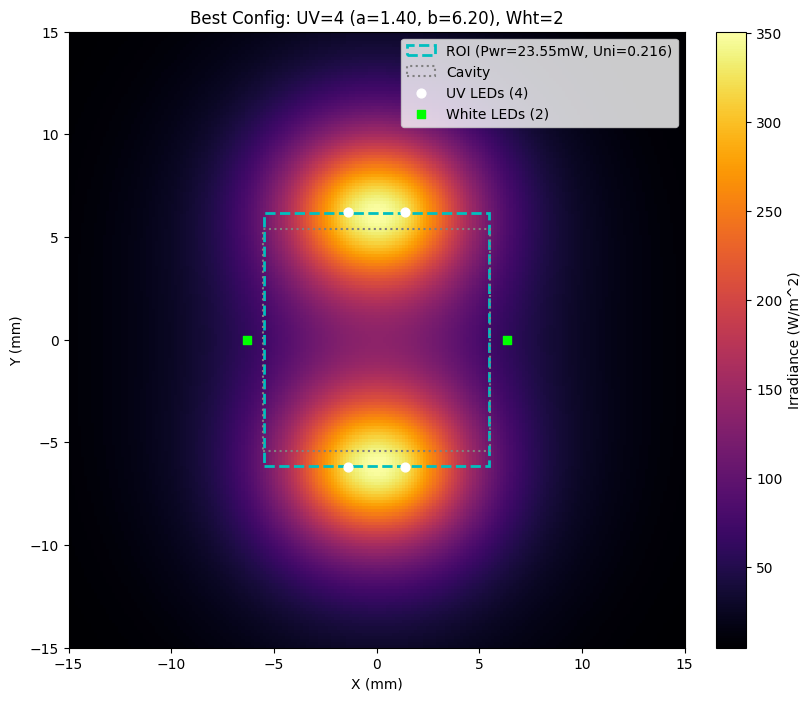


--- Plotting Normalized X=0 and Y=0 Line Profiles across ROI ---


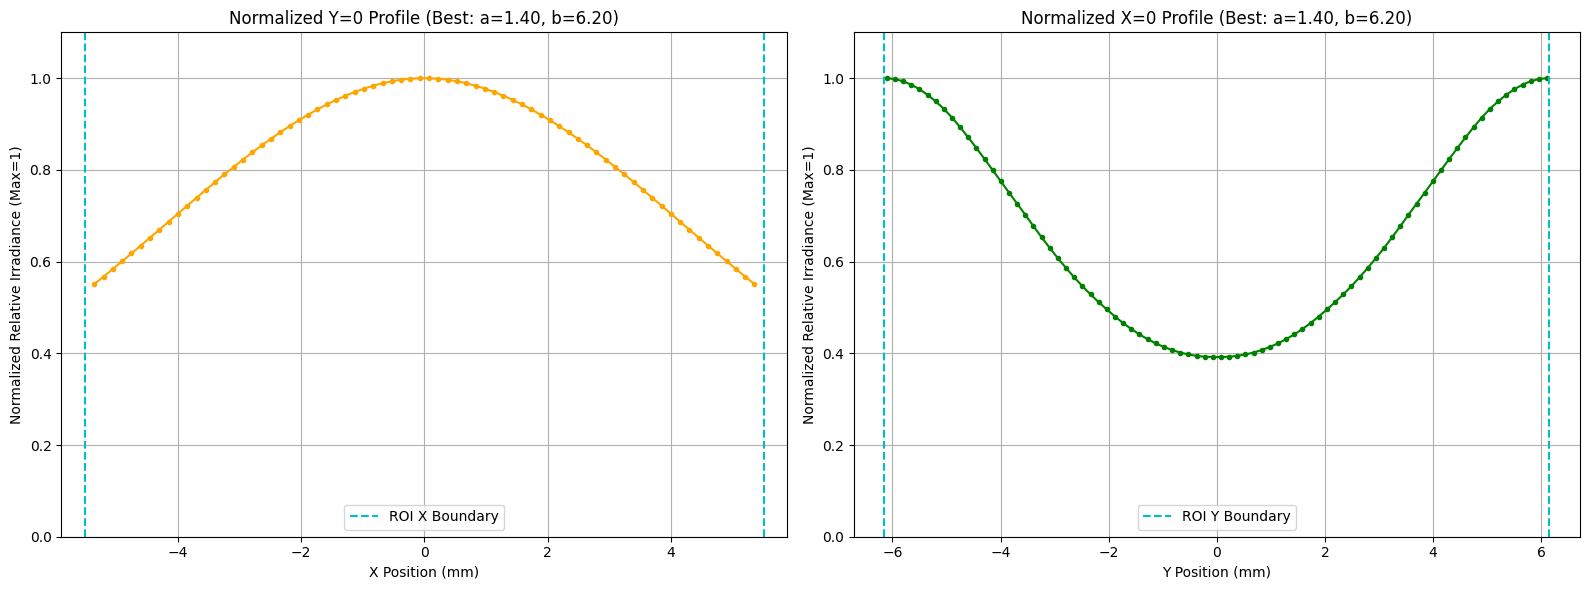


--- Plotting Normalized Diagonal Line Profile across ROI ---


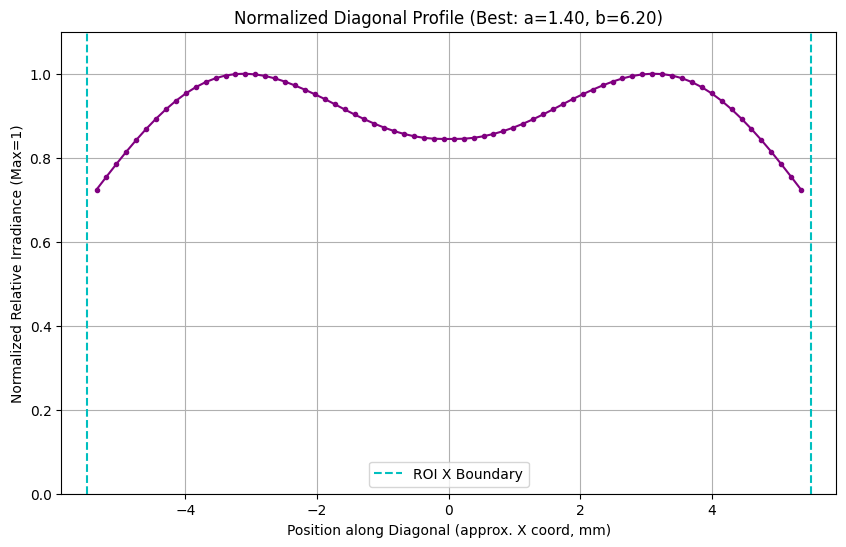

In [ ]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import interp1d
import pandas as pd
from datetime import datetime
import itertools

# ======================================================================================
# 1. 시뮬레이션 파라미터 및 최적화 설정
# ======================================================================================
# --- 광학계 기본 설정 ---
PHASEMASK_TO_OBJECT_DISTANCE_MM = 6.0
ROI_WIDTH_MM = 11.0
ROI_HEIGHT_MM = 12.3

# # # --- 시나리오 A 기구적 수치 ---
# LED_THICKNESS_MM = 2.3
# OTHER_PARTS_THICKNESS_MM = 0.1
# CAVITY_WIDTH_MM = 6.45
# CAVITY_HEIGHT_MM = 3.63

# --- 시나리오 B 기구적 수치 ---
LED_THICKNESS_MM = 2.3
OTHER_PARTS_THICKNESS_MM = 0.1
CAVITY_WIDTH_MM = 11.06
CAVITY_HEIGHT_MM = 10.81

# --- LED 특성 ---
LED_ANGLES_DEG_ORIGINAL = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
LED_INTENSITIES_ORIGINAL = np.array([1.0, 0.99, 0.98, 0.95, 0.90, 0.82, 0.70, 0.50, 0.25, 0.0])
PASSIVATION_SPREAD_FACTOR = 1.07 # 임의로 정한 빔 퍼짐 정도
LED_ANGLES_DEG = np.clip(LED_ANGLES_DEG_ORIGINAL * PASSIVATION_SPREAD_FACTOR, 0, 95); LED_ANGLES_DEG[0]=0
LED_INTENSITIES = LED_INTENSITIES_ORIGINAL
SINGLE_LED_TOTAL_POWER_MW = 15.832 # 사용자 입력값 (보정된 값)

# --- ✨ NEW! ✨ 고정된 LED 개수 및 (a, b) 좌표 탐색 범위 ---
NUM_UV_LEDS = 4 # UV LED 개수 고정
NUM_WHITE_LEDS = 2 # White LED 개수 고정
A_RANGE_MM = np.arange(1.0, 8.1, 0.2) # 'a' 좌표 탐색 범위 (mm)
B_RANGE_MM = np.arange(CAVITY_HEIGHT_MM/2 + 0.8, 9.1, 0.2) # 'b' 좌표 탐색 범위 (mm)
MIN_LED_SEPARATION_MM = 2.5 # LED 물리적 최소 간격

# --- White LED 설정 ---
CROSSTALK_MIN_DISTANCE_MM = 5.0
WHITE_LED_X_OFFSET_MM = CAVITY_WIDTH_MM/2 + 0.8 # White LED를 배치할 X축 거리 (Cavity 바깥쪽) # 4.5

# --- 시뮬레이션 정밀도 ---
RESOLUTION = 200
GRID_SIZE_MM = 30
MM_PER_M = 1000.0

# --- Loss Function 가중치 (W_COUNT 제거) ---
W_POWER = 1000.0
W_UNIFORMITY = 100.0
W_CROSSTALK = 100000.0 # Crosstalk 페널티는 여전히 매우 높게 유지
TARGET_POWER_MW = 34.0

# ======================================================================================
# 2. 핵심 함수 (배치 함수 수정, Crosstalk 함수 수정, Loss 함수 수정)
# ======================================================================================
def get_beam_profile_func(angles, intensities):
    f = interp1d(angles, intensities, kind='linear', fill_value=0.0, bounds_error=False)
    return f

# ✨ NEW! ✨ (a, b) 좌표 기반 4개 UV LED 배치 및 유효성 검사 함수
def create_4_symmetric_uv_layout(a, b, cavity_w, cavity_h, min_separation):
    """
    (a, b) 좌표를 사용하여 (±a, ±b) 위치에 4개의 UV LED를 배치하고 유효성을 검사합니다.
    유효하지 않으면 빈 리스트를 반환합니다.
    """
    positions = [
        np.array([a, b, 0]), np.array([-a, b, 0]),
        np.array([-a, -b, 0]), np.array([a, -b, 0])
    ]
    
    # 1. Cavity 침범 검사
    for x, y, z in positions:
        if abs(x) < cavity_w / 2.0 and abs(y) < cavity_h / 2.0:
            # print(f"    Skipping (a={a:.2f}, b={b:.2f}): LED at ({x:.2f},{y:.2f}) inside cavity")
            return [] # Cavity 침범 시 무효

    # 2. 최소 간격 검사 (인접 LED 간 거리)
    dist1 = np.linalg.norm(positions[0] - positions[1]) # (a,b) vs (-a,b) -> 2a
    dist2 = np.linalg.norm(positions[0] - positions[3]) # (a,b) vs (a,-b) -> 2b
    if dist1 < min_separation or dist2 < min_separation:
        # print(f"    Skipping (a={a:.2f}, b={b:.2f}): Separation constraint violated (2a={dist1:.2f}, 2b={dist2:.2f} vs {min_separation:.2f})")
        return [] # 최소 간격 위반 시 무효

    return positions

# ✨ MODIFIED! ✨ White LED 배치 및 Crosstalk 검사 함수 (고정 위치 사용)
def place_white_leds_fixed_xaxis(uv_led_positions, x_white, num_white_target, min_dist):
    """
    X축 상의 고정된 위치(±x_white, 0)에 White LED를 배치하고 Crosstalk를 검사합니다.
    """
    candidate_slots = [
        np.array([x_white, 0, 0]),
        np.array([-x_white, 0, 0])
    ]
    
    selected_white_positions = []
    placement_successful = True
    
    # Check if candidate slots are too close to any UV LED
    for slot in candidate_slots:
         slot_ok = True
         for uv_pos in uv_led_positions:
             if np.linalg.norm(slot - uv_pos) < min_dist:
                 slot_ok = False
                 break
         if slot_ok:
             selected_white_positions.append(slot)

    # Need to place exactly num_white_target
    if len(selected_white_positions) < num_white_target:
        placement_successful = False
        selected_white_positions = [] # Failed placement

    # Return only the required number (handles cases where more than needed are valid)
    selected_white_positions = selected_white_positions[:num_white_target]
    
    crosstalk_penalty = 0.0 if placement_successful else W_CROSSTALK

    return selected_white_positions, crosstalk_penalty

# ... simulate_illumination, analyze_roi 함수는 이전 코드와 동일 ...
def simulate_illumination(led_positions, beam_profile_func, target_z, grid_size, resolution):
    x_coords=np.linspace(-grid_size / 2, grid_size / 2, resolution); y_coords=np.linspace(-grid_size / 2, grid_size / 2, resolution)
    X, Y=np.meshgrid(x_coords, y_coords); total_illum_map=np.zeros_like(X)
    for led_pos in led_positions:
        vectors_to_led=led_pos - np.stack([X, Y, np.full_like(X, target_z)], axis=-1)
        distances=np.linalg.norm(vectors_to_led, axis=-1); distances=np.where(distances==0, 1e-9, distances)
        cos_theta=(target_z - led_pos[2]) / distances
        angle_degrees=np.degrees(np.arccos(np.clip(cos_theta, 0, 1)))
        beam_intensity=beam_profile_func(angle_degrees)
        intensity_contribution=(beam_intensity * cos_theta) / (distances**2)
        total_illum_map += intensity_contribution
    return X, Y, total_illum_map

def analyze_roi(X, Y, illum_map, roi_w, roi_h, effective_single_led_power_mw, num_leds):
    roi_mask=(np.abs(X) <= roi_w / 2) & (np.abs(Y) <= roi_h / 2)
    roi_illum=np.where(roi_mask, illum_map, np.nan)
    if np.all(np.isnan(roi_illum)): return 0, 0, 0.0
    dx=X[0, 1] - X[0, 0]; dy=Y[1, 0] - Y[0, 0]; pixel_area_mm2=dx * dy
    sim_total_integral=np.sum(illum_map[~np.isnan(illum_map)]) * pixel_area_mm2
    total_led_power_mw_reference=effective_single_led_power_mw * num_leds
    scale_factor=(total_led_power_mw_reference / sim_total_integral) if sim_total_integral > 0 else 0.0
    roi_power_mw=np.nansum(roi_illum) * pixel_area_mm2 * scale_factor
    uniformity=np.nanmin(roi_illum) / np.nanmax(roi_illum) if np.nanmax(roi_illum) > 0 else 0
    return roi_power_mw, uniformity, scale_factor

# ✨ MODIFIED! ✨ Loss Function 계산 함수 (num_uv 입력 제거)
def calculate_loss(power_roi, uniformity_roi, crosstalk_penalty):
    """정의된 가중치를 사용하여 Loss 값을 계산합니다."""
    power_penalty = max(0, TARGET_POWER_MW - power_roi)
    uniformity_penalty = (1.0 - uniformity_roi)
    loss = (W_POWER * power_penalty +
            W_UNIFORMITY * uniformity_penalty +
            crosstalk_penalty)
    return loss, power_penalty, uniformity_penalty

# ======================================================================================
# 3. 로그 기록 함수 (이전과 동일)
# ======================================================================================
def log_simulation_result(log_file, data):
    try: df = pd.read_csv(log_file)
    except FileNotFoundError: df = pd.DataFrame(columns=data.keys())
    new_log = pd.DataFrame([data]); df = pd.concat([df, new_log], ignore_index=True)
    df.to_csv(log_file, index=False); print(f"\n✅ Optimization results logged to '{log_file}'")

# ======================================================================================
# 4. 최적화 실행 및 결과 처리 (루프 구조 변경)
# ======================================================================================
if __name__ == "__main__":
    
    # actual_led_object_distance = PHASEMASK_TO_OBJECT_DISTANCE_MM - OTHER_PARTS_THICKNESS_MM - LED_THICKNESS_MM # A
    actual_led_object_distance = 4.74
    beam_func = get_beam_profile_func(LED_ANGLES_DEG, LED_INTENSITIES)
    
    if SINGLE_LED_TOTAL_POWER_MW == INITIAL_SINGLE_LED_POWER_MW:
        print("\nWARNING: SINGLE_LED_TOTAL_POWER_MW might need calibration.")
        print("         Using the initial value for optimization.")
        
    results_list = []
    
    # ✨ MODIFIED! ✨ 파라미터 조합 생성 ((a, b) 좌표)
    param_combinations = list(itertools.product(A_RANGE_MM, B_RANGE_MM))
    total_combinations = len(param_combinations)
    print(f"--- Starting Optimization Search ({total_combinations} combinations) ---")
    print(f"    Fixed UV LEDs: {NUM_UV_LEDS}, Fixed White LEDs: {NUM_WHITE_LEDS}")
    print(f"    'a' Range (mm): {A_RANGE_MM}")
    print(f"    'b' Range (mm): {B_RANGE_MM}")
    print(f"    Min LED Separation Constraint: >= {MIN_LED_SEPARATION_MM:.2f} mm")
    print(f"    White LED Crosstalk Constraint: >= {CROSSTALK_MIN_DISTANCE_MM:.2f} mm")
    print("-" * 60)
    start_time_total = datetime.now()
    
    # 모든 (a, b) 조합에 대해 시뮬레이션 실행
    for idx, (a, b) in enumerate(param_combinations):
        
        # 1. UV LED 배치 생성 및 유효성 검사
        uv_led_positions = create_4_symmetric_uv_layout(a, b, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, MIN_LED_SEPARATION_MM)
        
        if not uv_led_positions: # 배치가 유효하지 않으면 건너뜀
            print(f"({idx+1}/{total_combinations}) a={a:.2f}, b={b:.2f} -> Skipped (Invalid UV Layout)")
            continue
            
        # 2. White LED 배치 및 Crosstalk 검사
        white_led_positions, crosstalk_penalty_value = place_white_leds_fixed_xaxis(
            uv_led_positions, WHITE_LED_X_OFFSET_MM, NUM_WHITE_LEDS, CROSSTALK_MIN_DISTANCE_MM
        )
        crosstalk_occurred = (crosstalk_penalty_value > 0)
        
        # 3. 시뮬레이션 실행 (UV LED만으로)
        X_mm, Y_mm, illum_map_arb = simulate_illumination(
            uv_led_positions, beam_func, actual_led_object_distance, GRID_SIZE_MM, RESOLUTION
        )
        
        # 4. ROI 분석
        power_on_roi, uniformity_roi, _ = analyze_roi(
            X_mm, Y_mm, illum_map_arb, ROI_WIDTH_MM, ROI_HEIGHT_MM, SINGLE_LED_TOTAL_POWER_MW, NUM_UV_LEDS
        )
        
        # 5. Loss Function 계산 (Num UV 항 없음)
        total_loss, power_pen, unif_pen = calculate_loss(
            power_on_roi, uniformity_roi, crosstalk_penalty_value
        )
        
        # 결과 저장
        results_list.append({
            'a_mm': round(a, 2),
            'b_mm': round(b, 2),
            'Num_UV_LEDs': NUM_UV_LEDS, # 고정값
            'Num_White_LEDs': NUM_WHITE_LEDS, # 고정값
            'Power_ROI_mW': round(power_on_roi, 2),
            'Uniformity_ROI': round(uniformity_roi, 3),
            'White_LED_Placeable': not crosstalk_occurred,
            'Total_Loss': round(total_loss, 2),
            'Power_Penalty': round(power_pen, 2),
            'Uniformity_Penalty': round(unif_pen, 3),
            'Crosstalk_Penalty': int(crosstalk_penalty_value)
        })
        
        print(f"({idx+1}/{total_combinations}) a={a:.2f}, b={b:.2f} -> Pwr={power_on_roi:.2f}, Uni={uniformity_roi:.3f}, Wht OK?={'Yes' if not crosstalk_occurred else 'No!'}, Loss={total_loss:.2f}")

    end_time_total = datetime.now()
    print("-" * 60)
    print(f"Optimization Search Finished. Total time: {end_time_total - start_time_total}")

    # --- 결과 처리 및 로깅 ---
    if not results_list:
        print("\nNo valid configurations found in the specified range.")
    else:
        results_df = pd.DataFrame(results_list)
        results_df_sorted = results_df.sort_values(by='Total_Loss').reset_index(drop=True)
        
        log_file = 'optimization_results_ab.csv' # 파일 이름 변경
        results_df_sorted.to_csv(log_file, index=False)
        print(f"\n✅ Optimization results logged to '{log_file}'")
        
        # --- 최적 후보 필터링 및 출력 ---
        valid_configs = results_df_sorted[(results_df_sorted['White_LED_Placeable'] == True) & (results_df_sorted['Power_Penalty'] == 0.0)]
        
        if valid_configs.empty:
            print("\n--- No configurations met all constraints. Showing best overall results: ---")
            print(results_df_sorted.head(5).to_string())
            best_config = results_df_sorted.iloc[0]
        else:
             print("\n--- Top 5 Valid Configurations (Met Power & White LED constraints, Lower Loss is better) ---")
             print(valid_configs.head(5).to_string())
             best_config = valid_configs.iloc[0]

        # --- 최적 후보 시각화 ---
        print(f"\n--- Visualizing Selected Best Configuration (Loss={best_config['Total_Loss']:.2f}) ---")
        best_a = best_config['a_mm']; best_b = best_config['b_mm']
        best_uv_leds = create_4_symmetric_uv_layout(best_a, best_b, CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, MIN_LED_SEPARATION_MM)
        best_white_leds, _ = place_white_leds_fixed_xaxis(best_uv_leds, WHITE_LED_X_OFFSET_MM, NUM_WHITE_LEDS, CROSSTALK_MIN_DISTANCE_MM)
        
        if not best_uv_leds:
             print("Error: Could not generate layout for the best configuration.")
        else:
            X_best, Y_best, illum_best = simulate_illumination(best_uv_leds, beam_func, actual_led_object_distance, GRID_SIZE_MM, RESOLUTION)
            power_best, uniformity_best, scale_factor_best = analyze_roi(X_best, Y_best, illum_best, ROI_WIDTH_MM, ROI_HEIGHT_MM, SINGLE_LED_TOTAL_POWER_MW, len(best_uv_leds))
            irradiance_map_best_W_m2 = illum_best * scale_factor_best * (MM_PER_M**2 / 1000.0)

            fig_best, ax_best = plt.subplots(figsize=(10, 8)); im_best = ax_best.imshow(irradiance_map_best_W_m2, extent=[-GRID_SIZE_MM/2, GRID_SIZE_MM/2, -GRID_SIZE_MM/2, GRID_SIZE_MM/2], cmap='inferno', origin='lower'); roi_rect_best = patches.Rectangle((-ROI_WIDTH_MM/2, -ROI_HEIGHT_MM/2), ROI_WIDTH_MM, ROI_HEIGHT_MM, lw=2, ec='c', fc='none', ls='--', label=f'ROI (Pwr={power_best:.2f}mW, Uni={uniformity_best:.3f})'); cavity_rect_best = patches.Rectangle((-CAVITY_WIDTH_MM/2, -CAVITY_HEIGHT_MM/2), CAVITY_WIDTH_MM, CAVITY_HEIGHT_MM, lw=1.5, ec='gray', fc='none', ls=':', label='Cavity'); ax_best.add_patch(roi_rect_best); ax_best.add_patch(cavity_rect_best)
            if best_uv_leds: uv_x = [p[0] for p in best_uv_leds]; uv_y = [p[1] for p in best_uv_leds]; ax_best.scatter(uv_x, uv_y, c='w', marker='o', s=40, label=f'UV LEDs ({len(best_uv_leds)})')
            if best_white_leds: wh_x = [p[0] for p in best_white_leds]; wh_y = [p[1] for p in best_white_leds]; ax_best.scatter(wh_x, wh_y, c='lime', marker='s', s=40, label=f'White LEDs ({len(best_white_leds)})')
            ax_best.set_title(f'Best Config: UV=4 (a={best_a:.2f}, b={best_b:.2f}), Wht={len(best_white_leds)}'); ax_best.set_xlabel('X (mm)'); ax_best.set_ylabel('Y (mm)'); ax_best.legend(); cbar_best = fig_best.colorbar(im_best, ax=ax_best, fraction=0.046, pad=0.04); cbar_best.set_label('Irradiance (W/m^2)'); plt.show()
            
#             # --- ✨ MODIFIED! ✨ 정규화된 대각선 라인 플롯 추가 ---
#             print("\n--- Plotting Normalized Diagonal Line Profile across ROI ---")
            
#             # 대각선 데이터 추출 (상대 조도 illum_best_arb 사용)
#             diagonal_data_arb = illum_best.diagonal()
#             x_diag = np.linspace(-GRID_SIZE_MM / 2, GRID_SIZE_MM / 2, RESOLUTION)
#             roi_diag_mask = (np.abs(x_diag) <= ROI_WIDTH_MM / 2) # X 기준 ROI 필터링
#             x_diag_roi = x_diag[roi_diag_mask]
#             diag_data_roi_arb = diagonal_data_arb[roi_diag_mask]
            
#             # 데이터 정규화
#             if len(diag_data_roi_arb) > 0:
#                 max_val_diag = np.nanmax(diag_data_roi_arb)
#                 diag_data_roi_normalized = diag_data_roi_arb / max_val_diag if max_val_diag > 0 else diag_data_roi_arb
#             else:
#                 diag_data_roi_normalized = []

#             # 라인 플롯 생성 (정규화된 데이터 사용)
#             if len(x_diag_roi) > 0 and len(diag_data_roi_normalized) > 0 :
#                 fig_diag, ax_diag = plt.subplots(figsize=(10, 6))
#                 ax_diag.plot(x_diag_roi, diag_data_roi_normalized, marker='.', linestyle='-', color='purple')
#                 ax_diag.set_title(f'Normalized Diagonal Line Profile (Best Config: a={best_a:.2f}, b={best_b:.2f})')
#                 ax_diag.set_xlabel('Position along Diagonal (approx. X coord, mm)')
#                 ax_diag.set_ylabel('Normalized Relative Irradiance (Max=1)')
#                 ax_diag.set_ylim(0, 1.1)
#                 ax_diag.grid(True)
#                 ax_diag.axvline(-ROI_WIDTH_MM/2, color='c', linestyle='--', label='ROI X Boundary')
#                 ax_diag.axvline(ROI_WIDTH_MM/2, color='c', linestyle='--')
#                 ax_diag.legend()
#                 plt.show()
#             else:
#                 print("No data points found along the diagonal within the ROI for the best configuration.")
#             # --- 대각선 라인 플롯 끝 ---
                # 데이터 정규화
            # --- ✨ MODIFIED! ✨ X=0 및 Y=0 정규화 라인 플롯 추가 ---
            print("\n--- Plotting Normalized X=0 and Y=0 Line Profiles across ROI ---")
            
            # X=0 (수직 중심선) 데이터 추출
            center_x_idx = RESOLUTION // 2
            line_data_y_arb = illum_best[:, center_x_idx] # 상대 조도
            y_coords_line = Y_best[:, center_x_idx] # Y 좌표
            
            # Y=0 (수평 중심선) 데이터 추출
            center_y_idx = RESOLUTION // 2
            line_data_x_arb = illum_best[center_y_idx, :] # 상대 조도
            x_coords_line = X_best[center_y_idx, :] # X 좌표

            # ROI 영역 필터링
            roi_y_mask = (np.abs(y_coords_line) <= ROI_HEIGHT_MM / 2)
            y_coords_roi = y_coords_line[roi_y_mask]
            line_data_y_roi_arb = line_data_y_arb[roi_y_mask]
            
            roi_x_mask = (np.abs(x_coords_line) <= ROI_WIDTH_MM / 2)
            x_coords_roi = x_coords_line[roi_x_mask]
            line_data_x_roi_arb = line_data_x_arb[roi_x_mask]
            
            # 데이터 정규화
            line_data_y_roi_normalized = []; line_data_x_roi_normalized = []
            if len(line_data_y_roi_arb) > 0:
                max_val_y = np.nanmax(line_data_y_roi_arb)
                line_data_y_roi_normalized = line_data_y_roi_arb / max_val_y if max_val_y > 0 else line_data_y_roi_arb
            if len(line_data_x_roi_arb) > 0:
                max_val_x = np.nanmax(line_data_x_roi_arb)
                line_data_x_roi_normalized = line_data_x_roi_arb / max_val_x if max_val_x > 0 else line_data_x_roi_arb

            # 두 개의 라인 플롯 생성
            fig_lines, (ax_x, ax_y) = plt.subplots(1, 2, figsize=(16, 6))

            # Y=0 라인 플롯
            if len(x_coords_roi) > 0 and len(line_data_x_roi_normalized) > 0:
                ax_x.plot(x_coords_roi, line_data_x_roi_normalized, marker='.', linestyle='-', color='orange')
                ax_x.set_title(f'Normalized Y=0 Profile (Best: a={best_a:.2f}, b={best_b:.2f})')
                ax_x.set_xlabel('X Position (mm)')
                ax_x.set_ylabel('Normalized Relative Irradiance (Max=1)')
                ax_x.set_ylim(0, 1.1)
                ax_x.grid(True)
                ax_x.axvline(-ROI_WIDTH_MM/2, color='c', linestyle='--', label='ROI X Boundary')
                ax_x.axvline(ROI_WIDTH_MM/2, color='c', linestyle='--')
                ax_x.legend()
            else: ax_x.set_title("No Y=0 data in ROI")

            # X=0 라인 플롯
            if len(y_coords_roi) > 0 and len(line_data_y_roi_normalized) > 0:
                ax_y.plot(y_coords_roi, line_data_y_roi_normalized, marker='.', linestyle='-', color='green')
                ax_y.set_title(f'Normalized X=0 Profile (Best: a={best_a:.2f}, b={best_b:.2f})')
                ax_y.set_xlabel('Y Position (mm)')
                ax_y.set_ylabel('Normalized Relative Irradiance (Max=1)')
                ax_y.set_ylim(0, 1.1)
                ax_y.grid(True)
                ax_y.axvline(-ROI_HEIGHT_MM/2, color='c', linestyle='--', label='ROI Y Boundary')
                ax_y.axvline(ROI_HEIGHT_MM/2, color='c', linestyle='--')
                ax_y.legend()
            else: ax_y.set_title("No X=0 data in ROI")

            plt.tight_layout()
            plt.show()
            # --- X=0, Y=0 라인 플롯 끝 ---

            # --- 대각선 라인 플롯 (이전 코드와 동일, 데이터 소스만 illum_best_arb) ---
            print("\n--- Plotting Normalized Diagonal Line Profile across ROI ---")
            diagonal_data_arb = illum_best.diagonal()
            x_diag = np.linspace(-GRID_SIZE_MM / 2, GRID_SIZE_MM / 2, RESOLUTION)
            roi_diag_mask = (np.abs(x_diag) <= ROI_WIDTH_MM / 2)
            x_diag_roi = x_diag[roi_diag_mask]
            diag_data_roi_arb = diagonal_data_arb[roi_diag_mask]
            diag_data_roi_normalized = []
            if len(diag_data_roi_arb) > 0:
                max_val_diag = np.nanmax(diag_data_roi_arb)
                diag_data_roi_normalized = diag_data_roi_arb / max_val_diag if max_val_diag > 0 else diag_data_roi_arb
            if len(x_diag_roi) > 0 and len(diag_data_roi_normalized) > 0 :
                fig_diag, ax_diag = plt.subplots(figsize=(10, 6))
                ax_diag.plot(x_diag_roi, diag_data_roi_normalized, marker='.', linestyle='-', color='purple')
                ax_diag.set_title(f'Normalized Diagonal Profile (Best: a={best_a:.2f}, b={best_b:.2f})')
                ax_diag.set_xlabel('Position along Diagonal (approx. X coord, mm)')
                ax_diag.set_ylabel('Normalized Relative Irradiance (Max=1)')
                ax_diag.set_ylim(0, 1.1); ax_diag.grid(True)
                ax_diag.axvline(-ROI_WIDTH_MM/2, color='c', linestyle='--', label='ROI X Boundary')
                ax_diag.axvline(ROI_WIDTH_MM/2, color='c', linestyle='--'); ax_diag.legend(); plt.show()
            else: print("No diagonal data in ROI.")
            # --- 대각선 라인 플롯 끝 ---